In [1]:
# install required packages here
!pip3 install numpy
!pip3 install torch
!pip3 install networkx
!pip3 install matplotlib
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.0 MB/s eta 0:00:00a 0:00:01


In [2]:
# import required packages here
import os
import torch
import scipy
import argparse
import seaborn
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset
from torch_geometric.datasets import TUDataset
from sklearn.model_selection import train_test_split
from torch_geometric.utils import to_dense_adj
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix



In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GCN(nn.Module):
    '''
    Implementation of a Graph Convolutional Network (GCN) layer with message passing, aggregation, and non-linearity.
    '''
    def __init__(self, in_feats, out_feats, device='cpu', use_bn=True):
        super(GCN, self).__init__()
        self.device = device
        self.use_bn = use_bn
        
        # Linear transformation (learnable weights for feature transformation)
        self.linear = nn.Linear(in_feats, out_feats, bias=True)
        
        # Xavier initialization of the weights, considering ReLU activation gain
        nn.init.xavier_uniform_(self.linear.weight, gain=nn.init.calculate_gain('relu'))

        # Optional Batch Normalization
        if self.use_bn:
            self.bn = nn.BatchNorm1d(out_feats)

    def forward(self, node_feats, adj_matrix):
        """
        Inputs:
            node_feats: Tensor of node features [batch_size, num_nodes, in_feats]
            adj_matrix: Adjacency matrix [batch_size, num_nodes, num_nodes]
        """
        
        # 1. Message Passing (Add self-loops to adjacency matrix to retain the node's own information)
        # Ensures that each node also passes its own features to itself (self-loops)
        adj_matrix = adj_matrix + torch.eye(adj_matrix.size(1)).to(self.device)
        
        # 2. Linear transformation (feature projection)
        # Apply learnable transformation to node features before aggregating
        node_feats = self.linear(node_feats)

        # 3. Aggregation (Neighbor information aggregation)
        # Compute the degree of each node (sum of neighbors' connections)
        num_neighbors = adj_matrix.sum(dim=-1, keepdim=True)  # Sum of incoming edges (degree matrix)
        
        # Avoid division by zero for isolated nodes
        num_neighbors[num_neighbors == 0] = 1.0

        # 4. Message Passing (Aggregating neighbors' features)
        # Multiply adjacency matrix with node features to aggregate features from neighbors
        node_feats = torch.bmm(adj_matrix, node_feats)

        # 5. Aggregation (Normalization by the number of neighbors)
        # Normalize node features by the number of neighbors to average the contribution
        node_feats = node_feats / num_neighbors
        
        # 6. Batch Normalization (Optional, applied to normalized features)
        # If batch normalization is used, reshape the tensor for batch normalization
        if self.use_bn:
            node_feats = node_feats.view(-1, node_feats.shape[-1])  # Reshape for batch norm
            node_feats = self.bn(node_feats)
            node_feats = node_feats.view(-1, adj_matrix.shape[1], node_feats.shape[-1])

        # 7. Non-linearity (Apply ReLU activation function)
        # Introduce non-linearity to the output to allow learning complex patterns
        node_feats = F.relu(node_feats)

        return node_feats


In [8]:
# Implementation of DownSamplePool Model
class DownSamplePool(nn.Module):
    '''
    Implementation of DownSample&Pool Module.
    '''
    def __init__(self, nfeat, nnext, k, device='cpu'):
        super(DownSamplePool, self).__init__()
        self.device = device
        self.k = k  # percentage of nodes to keep (e.g., 0.9)
        self.proj = nn.Linear(nfeat, 1)  # Projection vector for gPool
        # GNNs for diffpool
        self.embed = GCN(nfeat, nfeat, device=self.device, use_bn=True)
        self.assign_mat = GCN(nfeat, nnext, device=self.device, use_bn=False)  # No batch norm on assignment

    def forward(self, x, adj):
        # x: (batch_size, num_nodes, nfeat)
        # adj: (batch_size, num_nodes, num_nodes)
        batch_size = x.size(0)
        num_nodes = x.size(1)

        # Compute projection scores
        scores = self.proj(x).squeeze(-1)  # (batch_size, num_nodes)
        # Get top k nodes
        k_num_nodes = int(self.k * num_nodes)
        topk_scores, idx = torch.topk(scores, k_num_nodes, dim=1)

        # Create mask
        mask = torch.zeros_like(scores)
        mask.scatter_(1, idx, 1)
        mask = mask.unsqueeze(-1)

        # Apply mask to x and adj
        x_down = x * mask
        adj_down = adj * mask
        adj_down = adj_down * mask.transpose(1, 2)

        # Apply diffpool
        z_l = self.embed(x_down, adj_down)
        s_l = F.softmax(self.assign_mat(x_down, adj_down), dim=-1)
        xnext = torch.matmul(s_l.transpose(1, 2), z_l)
        anext = torch.matmul(torch.matmul(s_l.transpose(1, 2), adj_down), s_l)
        return xnext, anext



In [10]:
# Classifier Class
class Classifier(nn.Module):
    def __init__(self, in_feats, n_classes, dropout_rate=0.3):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(in_feats, 100),  # Increased complexity
            nn.ReLU(),
            nn.BatchNorm1d(100),  # Batch normalization after first linear layer
            nn.Dropout(dropout_rate),  # Dropout for regularization
            nn.Linear(100, 50),  # Intermediate layer
            nn.ReLU(),
            nn.BatchNorm1d(50),  # Batch normalization after second linear layer
            nn.Dropout(dropout_rate),  # Dropout before final output
            nn.Linear(50, n_classes)
        )

    def forward(self, x):
        return self.classifier(x)


    # Implementation of Additional Util Classes (If Needed)
class CollateFn:
    def __init__(self, device='cpu'):
        self.device = device

    def __call__(self, batch):
        adj_tensor_list = []
        features_list = []
        labels = []

        max_num_nodes = max(item.x.shape[0] for item in batch)

        for d in batch:
            A = to_dense_adj(d.edge_index).squeeze(0)
            F = d.x
            L = d.y

            labels.append(L)
            length = F.shape[0]
            pad_len_F = max_num_nodes - length
            pad_len_A = max_num_nodes - A.shape[0]

            adj_tensor_list.append(np.pad(A, ((0, pad_len_A), (0, pad_len_A)), mode='constant'))
            features_list.append(np.pad(F, ((0, pad_len_F), (0, 0)), mode='constant'))

        stacked_adj = torch.from_numpy(np.stack(adj_tensor_list, 0)).float().to(self.device)
        stacked_feat = torch.from_numpy(np.stack(features_list, 0)).float().to(self.device)
        stacked_y = torch.from_numpy(np.stack(labels, 0)).long().to(self.device)

        return stacked_adj, stacked_feat, stacked_y

In [12]:
import torch
import torch.nn as nn

# Main Model Class
class Model(nn.Module):
    '''
    Architecture of Overall Graph Classifier.
    '''
    def __init__(self, device, input_shape, n_classes, k_values, m_values, dropout_rate=0.3):
        super().__init__()
        self.input_shape = input_shape
        self.device = device
        self.dropout_rate = dropout_rate

        self.layers = nn.ModuleList([
            GCN(input_shape, 64, device=self.device, use_bn=True),  # Increased output dimensions
            nn.Dropout(p=self.dropout_rate),  # Dropout after the first GCN layer

            GCN(64, 64, device=self.device, use_bn=True),
            DownSamplePool(64, m_values[0], k_values[0], device=self.device),
            nn.Dropout(p=self.dropout_rate),  # Dropout after DownSamplePool layer

            GCN(64, 128, device=self.device, use_bn=True),  # Increased output dimensions
            nn.Dropout(p=self.dropout_rate),  # Dropout after this GCN layer
            
            GCN(128, 128, device=self.device, use_bn=True),
            DownSamplePool(128, m_values[1], k_values[1], device=self.device),
            nn.Dropout(p=self.dropout_rate)  # Dropout after the second DownSamplePool layer
        ])

        self.classifier = Classifier(128, n_classes, dropout_rate=dropout_rate)  # Update input features for classifier

    def forward(self, x, adj):
        for layer in self.layers:
            if isinstance(layer, GCN):
                x = layer(x, adj)
            elif isinstance(layer, DownSamplePool):
                x, adj = layer(x, adj)
            elif isinstance(layer, nn.Dropout):
                x = layer(x)  # Apply dropout to the output of previous layers

        # Final readout
        readout_x = x.sum(dim=1)
        output = self.classifier(readout_x)
        return output

    def loss(self, output, labels):
        criterion = nn.CrossEntropyLoss()
        loss = criterion(output, labels)
        return loss


In [13]:
# Implementation of Additional Classes for loading dataset and preparing data loader (If Needed)
'''
Write your Code here
'''
def load_dataset(dataset_name):
    dataset = TUDataset(root='/content/' + dataset_name, name=dataset_name)
    return dataset

def split_data(dataset, train_size, val_size, test_size):
    train, val, test = random_split(dataset, [train_size, val_size, test_size])
    return train, val, test
    
    
def prepare_dataloader(train, val, test, batch_size, device):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Prepare DataLoaders
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, collate_fn=CollateFn(device))
    val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, collate_fn=CollateFn(device))
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, collate_fn=CollateFn(device))
    
    return train_loader, val_loader, test_loader
    
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import os

def train_model(model, train_loader, val_loader, epochs, train_size, val_size, save_path, device):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#     scheduler = StepLR(optimizer, step_size=50, gamma=0.1)
    best_val_acc = 0
    train_losses = []
    val_losses = []
    
    for e in tqdm(range(epochs)):
        model.train()
        epoch_losses_list = []
        true_sample = 0
        for i, (adj, features, batch_labels) in enumerate(train_loader):
            output = model(features, adj)
            batch_labels = batch_labels.squeeze(1)
            loss = model.loss(output, batch_labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
            optimizer.step()
            optimizer.zero_grad()
            epoch_losses_list.append(loss.item())
            iter_true_sample = (output.argmax(dim=1).long() == batch_labels.long()).float().sum().item()
            true_sample += iter_true_sample
        train_acc = true_sample / train_size

        # Validation
        model.eval()
        val_loss_list = []
        true_sample = 0
        with torch.no_grad():
            for i, (adj, features, batch_labels) in enumerate(val_loader):
                output = model(features, adj)
                batch_labels = batch_labels.squeeze(1)
                loss = model.loss(output, batch_labels)
                val_loss_list.append(loss.item())
                iter_true_sample = (output.argmax(dim=1).long() == batch_labels.long()).float().sum().item()
                true_sample += iter_true_sample
        val_acc = true_sample / val_size
        train_loss = np.mean(epoch_losses_list)
        val_loss = np.mean(val_loss_list)

        print(f"Epoch:{e}, Train Loss:{train_loss:.4f}, Train Acc:{train_acc:.2f}, Val Loss:{val_loss:.4f}, Val Acc:{val_acc:.2f}")
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            save_model(model, save_path)  # Save the best model
        
#         scheduler.step()

    return train_losses, val_losses, best_val_acc


def save_model(model, path):
    """Save the model to disk."""
    # If the directory exists
    directory = os.path.dirname(path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # Save the model
    torch.save(model.state_dict(), path)
    print(f"Model saved at {path}")


def load_model(model, path, device):
    """Load the model from disk."""
    model.load_state_dict(torch.load(path, map_location=device))
    print(f"Model loaded from {path}")
    return model


def evaluate_model(model, test_loader, test_size, n_classes, device):
    """Evaluate the model on the test set and show the classification report and confusion matrix."""
    model.eval()
    true_sample = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for i, (adj, features, batch_labels) in enumerate(test_loader):
            output = model(features, adj)
            batch_labels = batch_labels.squeeze(1)
            iter_true_sample = (output.argmax(dim=1).long() == batch_labels.long()).float().sum().item()
            all_preds.append(output.argmax(dim=1).cpu().numpy())  # Collect predictions
            all_labels.append(batch_labels.cpu().numpy())         # Collect true labels
            true_sample += iter_true_sample
    test_acc = true_sample / test_size
    print(f"Test Accuracy: {test_acc:.2f}")

    # Convert collected predictions and labels to numpy arrays
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Generate and display the classification report
    print("Classification Report:\n")
    print(classification_report(all_labels, all_preds))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(n_classes), yticklabels=range(n_classes))
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    return test_acc
    

def run_experiment(dataset_name, k_values, m_values, batch_size, epochs, device):
    """Runs the entire experiment (training, saving, loading, and evaluating) for a specific dataset."""
    # Load dataset
    dataset = load_dataset(dataset_name)
    n_classes = dataset.num_classes
    input_shape = dataset.num_node_features
    dataset_size = len(dataset)
    train_size = int(0.8 * dataset_size)
    val_size = int(0.1 * dataset_size)
    test_size = dataset_size - train_size - val_size

    # Split dataset and prepare data loaders
    train, val, test = split_data(dataset, train_size, val_size, test_size)
    train_loader, val_loader, test_loader = prepare_dataloader(train, val, test, batch_size, device)

    # Initialize model
    model = Model(device, input_shape, n_classes, k_values, m_values).to(device)
    model_save_path = os.path.join("models", f"best_model_{dataset_name}.pth")
    
    # Train the model and save the best one
    train_losses, val_losses, best_val_acc = train_model(model, train_loader, val_loader, epochs, train_size, val_size, model_save_path, device)

    # Plot training and validation loss
    plt.figure()
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Training and Validation Loss for {dataset_name}")
    plt.show()

    # Load the best model from disk
    model = load_model(model, model_save_path, device)

    # Evaluate the model on the test set
    test_acc = evaluate_model(model, test_loader, test_size, n_classes, device)

    # Print the final results
    print(f"Best Validation Accuracy for {dataset_name}: {best_val_acc:.2f}")
    print(f"Test Accuracy for {dataset_name}: {test_acc:.2f}")


In [15]:
def main():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Hyperparameters for k values
    k_values_list = [[0.9, 0.9], [0.8, 0.8], [0.6, 0.6]]  # List of k values to experiment with
    m_values = [6, 3]  # m values for diffpool layers
    batch_size = 20
    epochs = 200

    # Run experiment for each k value in k_values_list
    for k_values in k_values_list:
        print(f"\nRunning experiment with k_values: {k_values[0]}")
        run_experiment('DD', k_values, m_values, batch_size, epochs, device)




Running experiment with k_values: 0.9


Processing...
Done!
  0%|          | 1/200 [00:10<34:13, 10.32s/it]

Epoch:0, Train Loss:0.6617, Train Acc:0.62, Val Loss:0.6430, Val Acc:0.59
Model saved at models/best_model_DD.pth


  1%|          | 2/200 [00:19<31:29,  9.54s/it]

Epoch:1, Train Loss:0.6445, Train Acc:0.67, Val Loss:0.5238, Val Acc:0.77
Model saved at models/best_model_DD.pth


  2%|▏         | 3/200 [00:28<30:36,  9.32s/it]

Epoch:2, Train Loss:0.6219, Train Acc:0.69, Val Loss:0.5713, Val Acc:0.62


  2%|▏         | 4/200 [00:37<30:03,  9.20s/it]

Epoch:3, Train Loss:0.5802, Train Acc:0.71, Val Loss:0.5054, Val Acc:0.78
Model saved at models/best_model_DD.pth


  2%|▎         | 5/200 [00:46<29:50,  9.18s/it]

Epoch:4, Train Loss:0.5403, Train Acc:0.74, Val Loss:0.6163, Val Acc:0.59


  3%|▎         | 6/200 [00:55<29:18,  9.06s/it]

Epoch:5, Train Loss:0.5615, Train Acc:0.73, Val Loss:0.5659, Val Acc:0.59


  4%|▎         | 7/200 [01:04<29:10,  9.07s/it]

Epoch:6, Train Loss:0.5581, Train Acc:0.74, Val Loss:0.5515, Val Acc:0.62


  4%|▍         | 8/200 [01:13<28:43,  8.98s/it]

Epoch:7, Train Loss:0.5289, Train Acc:0.74, Val Loss:0.5563, Val Acc:0.62


  4%|▍         | 9/200 [01:20<27:00,  8.49s/it]

Epoch:8, Train Loss:0.5500, Train Acc:0.75, Val Loss:0.6202, Val Acc:0.59


  5%|▌         | 10/200 [01:29<27:34,  8.71s/it]

Epoch:9, Train Loss:0.5335, Train Acc:0.76, Val Loss:0.5760, Val Acc:0.63


  6%|▌         | 11/200 [01:38<27:42,  8.80s/it]

Epoch:10, Train Loss:0.5158, Train Acc:0.78, Val Loss:0.6511, Val Acc:0.59


  6%|▌         | 12/200 [01:47<27:47,  8.87s/it]

Epoch:11, Train Loss:0.4934, Train Acc:0.77, Val Loss:0.6217, Val Acc:0.60


  6%|▋         | 13/200 [01:57<28:03,  9.00s/it]

Epoch:12, Train Loss:0.5258, Train Acc:0.75, Val Loss:0.6605, Val Acc:0.59


  7%|▋         | 14/200 [02:06<27:55,  9.01s/it]

Epoch:13, Train Loss:0.5304, Train Acc:0.75, Val Loss:0.5234, Val Acc:0.67


  8%|▊         | 15/200 [02:15<27:47,  9.01s/it]

Epoch:14, Train Loss:0.5253, Train Acc:0.75, Val Loss:0.4589, Val Acc:0.79
Model saved at models/best_model_DD.pth


  8%|▊         | 16/200 [02:23<27:24,  8.94s/it]

Epoch:15, Train Loss:0.4732, Train Acc:0.78, Val Loss:0.6376, Val Acc:0.59


  8%|▊         | 17/200 [02:32<27:09,  8.91s/it]

Epoch:16, Train Loss:0.4866, Train Acc:0.79, Val Loss:0.5365, Val Acc:0.67


  9%|▉         | 18/200 [02:41<27:06,  8.94s/it]

Epoch:17, Train Loss:0.4845, Train Acc:0.77, Val Loss:0.8229, Val Acc:0.59


 10%|▉         | 19/200 [02:50<26:31,  8.79s/it]

Epoch:18, Train Loss:0.4732, Train Acc:0.77, Val Loss:0.5941, Val Acc:0.62


 10%|█         | 20/200 [02:59<26:36,  8.87s/it]

Epoch:19, Train Loss:0.4790, Train Acc:0.78, Val Loss:0.6834, Val Acc:0.60


 10%|█         | 21/200 [03:08<26:42,  8.95s/it]

Epoch:20, Train Loss:0.4860, Train Acc:0.77, Val Loss:0.7460, Val Acc:0.59


 11%|█         | 22/200 [03:17<26:37,  8.98s/it]

Epoch:21, Train Loss:0.5273, Train Acc:0.76, Val Loss:0.6435, Val Acc:0.60


 12%|█▏        | 23/200 [03:26<26:30,  8.99s/it]

Epoch:22, Train Loss:0.4861, Train Acc:0.78, Val Loss:0.5941, Val Acc:0.62


 12%|█▏        | 24/200 [03:35<26:29,  9.03s/it]

Epoch:23, Train Loss:0.4766, Train Acc:0.79, Val Loss:0.4731, Val Acc:0.79


 12%|█▎        | 25/200 [03:44<26:09,  8.97s/it]

Epoch:24, Train Loss:0.4889, Train Acc:0.80, Val Loss:0.4762, Val Acc:0.78


 13%|█▎        | 26/200 [03:53<26:14,  9.05s/it]

Epoch:25, Train Loss:0.4693, Train Acc:0.79, Val Loss:0.6168, Val Acc:0.62


 14%|█▎        | 27/200 [04:02<26:04,  9.04s/it]

Epoch:26, Train Loss:0.4985, Train Acc:0.77, Val Loss:0.4466, Val Acc:0.77


 14%|█▍        | 28/200 [04:11<25:59,  9.07s/it]

Epoch:27, Train Loss:0.5063, Train Acc:0.78, Val Loss:0.7244, Val Acc:0.59


 14%|█▍        | 29/200 [04:20<25:49,  9.06s/it]

Epoch:28, Train Loss:0.4431, Train Acc:0.80, Val Loss:0.8533, Val Acc:0.59


 15%|█▌        | 30/200 [04:29<25:21,  8.95s/it]

Epoch:29, Train Loss:0.4791, Train Acc:0.78, Val Loss:0.6149, Val Acc:0.60


 16%|█▌        | 31/200 [04:38<25:21,  9.00s/it]

Epoch:30, Train Loss:0.4971, Train Acc:0.79, Val Loss:0.7100, Val Acc:0.61


 16%|█▌        | 32/200 [04:47<24:52,  8.89s/it]

Epoch:31, Train Loss:0.4546, Train Acc:0.80, Val Loss:0.4743, Val Acc:0.75


 16%|█▋        | 33/200 [04:56<24:52,  8.94s/it]

Epoch:32, Train Loss:0.4850, Train Acc:0.77, Val Loss:0.6126, Val Acc:0.62


 17%|█▋        | 34/200 [05:04<24:17,  8.78s/it]

Epoch:33, Train Loss:0.4651, Train Acc:0.80, Val Loss:0.6037, Val Acc:0.64


 18%|█▊        | 35/200 [05:14<24:29,  8.90s/it]

Epoch:34, Train Loss:0.4675, Train Acc:0.79, Val Loss:0.4286, Val Acc:0.81
Model saved at models/best_model_DD.pth


 18%|█▊        | 36/200 [05:22<24:21,  8.91s/it]

Epoch:35, Train Loss:0.4914, Train Acc:0.80, Val Loss:0.6458, Val Acc:0.64


 18%|█▊        | 37/200 [05:32<24:24,  8.99s/it]

Epoch:36, Train Loss:0.4164, Train Acc:0.81, Val Loss:1.0493, Val Acc:0.60


 19%|█▉        | 38/200 [05:41<24:28,  9.06s/it]

Epoch:37, Train Loss:0.4073, Train Acc:0.82, Val Loss:0.4857, Val Acc:0.79


 20%|█▉        | 39/200 [05:50<24:27,  9.12s/it]

Epoch:38, Train Loss:0.4154, Train Acc:0.80, Val Loss:0.5359, Val Acc:0.73


 20%|██        | 40/200 [05:59<24:18,  9.11s/it]

Epoch:39, Train Loss:0.4501, Train Acc:0.82, Val Loss:0.5443, Val Acc:0.77


 20%|██        | 41/200 [06:08<24:03,  9.08s/it]

Epoch:40, Train Loss:0.4441, Train Acc:0.78, Val Loss:0.6011, Val Acc:0.63


 21%|██        | 42/200 [06:17<23:47,  9.04s/it]

Epoch:41, Train Loss:0.4093, Train Acc:0.81, Val Loss:0.6558, Val Acc:0.65


 22%|██▏       | 43/200 [06:26<23:43,  9.07s/it]

Epoch:42, Train Loss:0.4329, Train Acc:0.82, Val Loss:0.3769, Val Acc:0.84
Model saved at models/best_model_DD.pth


 22%|██▏       | 44/200 [06:35<23:20,  8.98s/it]

Epoch:43, Train Loss:0.4078, Train Acc:0.81, Val Loss:0.5762, Val Acc:0.67


 22%|██▎       | 45/200 [06:44<23:13,  8.99s/it]

Epoch:44, Train Loss:0.4020, Train Acc:0.81, Val Loss:0.9052, Val Acc:0.60


 23%|██▎       | 46/200 [06:53<23:19,  9.09s/it]

Epoch:45, Train Loss:0.4219, Train Acc:0.84, Val Loss:0.5423, Val Acc:0.74


 24%|██▎       | 47/200 [07:02<23:11,  9.09s/it]

Epoch:46, Train Loss:0.3911, Train Acc:0.82, Val Loss:0.4988, Val Acc:0.74


 24%|██▍       | 48/200 [07:12<22:59,  9.08s/it]

Epoch:47, Train Loss:0.3814, Train Acc:0.83, Val Loss:0.7333, Val Acc:0.65


 24%|██▍       | 49/200 [07:21<22:49,  9.07s/it]

Epoch:48, Train Loss:0.4298, Train Acc:0.81, Val Loss:0.4445, Val Acc:0.81


 25%|██▌       | 50/200 [07:29<22:29,  8.99s/it]

Epoch:49, Train Loss:0.3928, Train Acc:0.83, Val Loss:0.6881, Val Acc:0.67


 26%|██▌       | 51/200 [07:39<22:26,  9.04s/it]

Epoch:50, Train Loss:0.4458, Train Acc:0.81, Val Loss:0.5367, Val Acc:0.69


 26%|██▌       | 52/200 [07:48<22:23,  9.08s/it]

Epoch:51, Train Loss:0.4154, Train Acc:0.81, Val Loss:0.5861, Val Acc:0.67


 26%|██▋       | 53/200 [07:57<22:11,  9.06s/it]

Epoch:52, Train Loss:0.4137, Train Acc:0.82, Val Loss:0.4590, Val Acc:0.77


 27%|██▋       | 54/200 [08:05<21:46,  8.95s/it]

Epoch:53, Train Loss:0.3753, Train Acc:0.84, Val Loss:0.5188, Val Acc:0.73


 28%|██▊       | 55/200 [08:14<21:36,  8.94s/it]

Epoch:54, Train Loss:0.3868, Train Acc:0.85, Val Loss:0.6070, Val Acc:0.72


 28%|██▊       | 56/200 [08:24<21:42,  9.04s/it]

Epoch:55, Train Loss:0.3485, Train Acc:0.85, Val Loss:0.6249, Val Acc:0.67


 28%|██▊       | 57/200 [08:33<21:38,  9.08s/it]

Epoch:56, Train Loss:0.3774, Train Acc:0.84, Val Loss:0.8711, Val Acc:0.64


 29%|██▉       | 58/200 [08:42<21:25,  9.05s/it]

Epoch:57, Train Loss:0.3686, Train Acc:0.84, Val Loss:0.5455, Val Acc:0.74


 30%|██▉       | 59/200 [08:51<21:19,  9.08s/it]

Epoch:58, Train Loss:0.3787, Train Acc:0.85, Val Loss:0.6040, Val Acc:0.71


 30%|███       | 60/200 [09:00<21:20,  9.15s/it]

Epoch:59, Train Loss:0.3673, Train Acc:0.85, Val Loss:0.7736, Val Acc:0.65


 30%|███       | 61/200 [09:09<21:04,  9.10s/it]

Epoch:60, Train Loss:0.3406, Train Acc:0.86, Val Loss:0.8000, Val Acc:0.68


 31%|███       | 62/200 [09:18<20:53,  9.08s/it]

Epoch:61, Train Loss:0.3533, Train Acc:0.85, Val Loss:0.5035, Val Acc:0.76


 32%|███▏      | 63/200 [09:27<20:45,  9.09s/it]

Epoch:62, Train Loss:0.3720, Train Acc:0.86, Val Loss:1.4408, Val Acc:0.60


 32%|███▏      | 64/200 [09:36<20:34,  9.08s/it]

Epoch:63, Train Loss:0.3770, Train Acc:0.84, Val Loss:0.4305, Val Acc:0.84


 32%|███▎      | 65/200 [09:45<20:13,  8.99s/it]

Epoch:64, Train Loss:0.3650, Train Acc:0.86, Val Loss:1.1067, Val Acc:0.60


 33%|███▎      | 66/200 [09:54<20:01,  8.97s/it]

Epoch:65, Train Loss:0.3618, Train Acc:0.84, Val Loss:0.7113, Val Acc:0.66


 34%|███▎      | 67/200 [10:03<20:02,  9.04s/it]

Epoch:66, Train Loss:0.3561, Train Acc:0.85, Val Loss:0.4835, Val Acc:0.79


 34%|███▍      | 68/200 [10:12<19:53,  9.04s/it]

Epoch:67, Train Loss:0.3573, Train Acc:0.85, Val Loss:0.4782, Val Acc:0.81


 34%|███▍      | 69/200 [10:21<19:39,  9.00s/it]

Epoch:68, Train Loss:0.3638, Train Acc:0.85, Val Loss:0.4251, Val Acc:0.84


 35%|███▌      | 70/200 [10:30<19:18,  8.91s/it]

Epoch:69, Train Loss:0.3683, Train Acc:0.85, Val Loss:0.4433, Val Acc:0.81


 36%|███▌      | 71/200 [10:39<19:17,  8.97s/it]

Epoch:70, Train Loss:0.3041, Train Acc:0.87, Val Loss:0.9983, Val Acc:0.62


 36%|███▌      | 72/200 [10:48<19:09,  8.98s/it]

Epoch:71, Train Loss:0.3533, Train Acc:0.86, Val Loss:1.1827, Val Acc:0.60


 36%|███▋      | 73/200 [10:57<18:49,  8.90s/it]

Epoch:72, Train Loss:0.3134, Train Acc:0.87, Val Loss:0.6998, Val Acc:0.76


 37%|███▋      | 74/200 [11:06<18:48,  8.96s/it]

Epoch:73, Train Loss:0.3307, Train Acc:0.85, Val Loss:0.7877, Val Acc:0.64


 38%|███▊      | 75/200 [11:15<18:47,  9.02s/it]

Epoch:74, Train Loss:0.3122, Train Acc:0.86, Val Loss:0.4778, Val Acc:0.82


 38%|███▊      | 76/200 [11:24<18:39,  9.03s/it]

Epoch:75, Train Loss:0.2961, Train Acc:0.86, Val Loss:0.6823, Val Acc:0.68


 38%|███▊      | 77/200 [11:33<18:22,  8.96s/it]

Epoch:76, Train Loss:0.3521, Train Acc:0.85, Val Loss:0.6037, Val Acc:0.72


 39%|███▉      | 78/200 [11:42<18:14,  8.97s/it]

Epoch:77, Train Loss:0.3270, Train Acc:0.86, Val Loss:1.1797, Val Acc:0.64


 40%|███▉      | 79/200 [11:51<18:01,  8.94s/it]

Epoch:78, Train Loss:0.3130, Train Acc:0.86, Val Loss:0.7504, Val Acc:0.69


 40%|████      | 80/200 [12:00<17:58,  8.98s/it]

Epoch:79, Train Loss:0.3293, Train Acc:0.85, Val Loss:0.9556, Val Acc:0.62


 40%|████      | 81/200 [12:09<17:50,  9.00s/it]

Epoch:80, Train Loss:0.3567, Train Acc:0.85, Val Loss:1.1928, Val Acc:0.64


 41%|████      | 82/200 [12:18<17:49,  9.06s/it]

Epoch:81, Train Loss:0.3000, Train Acc:0.87, Val Loss:0.7650, Val Acc:0.67


 42%|████▏     | 83/200 [12:27<17:41,  9.07s/it]

Epoch:82, Train Loss:0.3309, Train Acc:0.87, Val Loss:0.9364, Val Acc:0.65


 42%|████▏     | 84/200 [12:36<17:29,  9.05s/it]

Epoch:83, Train Loss:0.3115, Train Acc:0.88, Val Loss:0.9397, Val Acc:0.66


 42%|████▎     | 85/200 [12:45<17:20,  9.05s/it]

Epoch:84, Train Loss:0.3019, Train Acc:0.87, Val Loss:0.5809, Val Acc:0.74


 43%|████▎     | 86/200 [12:54<17:12,  9.05s/it]

Epoch:85, Train Loss:0.3400, Train Acc:0.86, Val Loss:0.6170, Val Acc:0.71


 44%|████▎     | 87/200 [13:03<17:04,  9.07s/it]

Epoch:86, Train Loss:0.2881, Train Acc:0.87, Val Loss:0.9675, Val Acc:0.64


 44%|████▍     | 88/200 [13:13<16:58,  9.09s/it]

Epoch:87, Train Loss:0.3276, Train Acc:0.87, Val Loss:1.4278, Val Acc:0.60


 44%|████▍     | 89/200 [13:22<16:47,  9.08s/it]

Epoch:88, Train Loss:0.3411, Train Acc:0.88, Val Loss:1.3360, Val Acc:0.62


 45%|████▌     | 90/200 [13:31<16:35,  9.05s/it]

Epoch:89, Train Loss:0.3235, Train Acc:0.87, Val Loss:0.8907, Val Acc:0.66


 46%|████▌     | 91/200 [13:40<16:28,  9.07s/it]

Epoch:90, Train Loss:0.2610, Train Acc:0.88, Val Loss:0.7042, Val Acc:0.73


 46%|████▌     | 92/200 [13:49<16:24,  9.12s/it]

Epoch:91, Train Loss:0.3034, Train Acc:0.88, Val Loss:0.7884, Val Acc:0.70


 46%|████▋     | 93/200 [13:58<16:11,  9.08s/it]

Epoch:92, Train Loss:0.2566, Train Acc:0.89, Val Loss:0.6461, Val Acc:0.73


 47%|████▋     | 94/200 [14:06<15:46,  8.93s/it]

Epoch:93, Train Loss:0.2948, Train Acc:0.89, Val Loss:0.9784, Val Acc:0.68


 48%|████▊     | 95/200 [14:16<15:51,  9.06s/it]

Epoch:94, Train Loss:0.3221, Train Acc:0.88, Val Loss:0.6128, Val Acc:0.72


 48%|████▊     | 96/200 [14:24<15:24,  8.89s/it]

Epoch:95, Train Loss:0.2854, Train Acc:0.90, Val Loss:1.0190, Val Acc:0.68


 48%|████▊     | 97/200 [14:33<15:22,  8.96s/it]

Epoch:96, Train Loss:0.3038, Train Acc:0.90, Val Loss:0.6076, Val Acc:0.72


 49%|████▉     | 98/200 [14:42<15:12,  8.94s/it]

Epoch:97, Train Loss:0.3377, Train Acc:0.88, Val Loss:0.7933, Val Acc:0.68


 50%|████▉     | 99/200 [14:51<15:03,  8.95s/it]

Epoch:98, Train Loss:0.2411, Train Acc:0.90, Val Loss:0.5928, Val Acc:0.79


 50%|█████     | 100/200 [15:00<14:49,  8.89s/it]

Epoch:99, Train Loss:0.2875, Train Acc:0.90, Val Loss:0.5512, Val Acc:0.78


 50%|█████     | 101/200 [15:09<14:45,  8.94s/it]

Epoch:100, Train Loss:0.3377, Train Acc:0.87, Val Loss:0.7804, Val Acc:0.68


 51%|█████     | 102/200 [15:19<14:48,  9.07s/it]

Epoch:101, Train Loss:0.3219, Train Acc:0.88, Val Loss:1.1122, Val Acc:0.62


 52%|█████▏    | 103/200 [15:28<14:41,  9.09s/it]

Epoch:102, Train Loss:0.2987, Train Acc:0.88, Val Loss:0.6155, Val Acc:0.76


 52%|█████▏    | 104/200 [15:35<13:46,  8.61s/it]

Epoch:103, Train Loss:0.2224, Train Acc:0.92, Val Loss:0.9203, Val Acc:0.68


 52%|█████▎    | 105/200 [15:44<13:47,  8.71s/it]

Epoch:104, Train Loss:0.2560, Train Acc:0.89, Val Loss:0.6385, Val Acc:0.74


 53%|█████▎    | 106/200 [15:53<13:49,  8.83s/it]

Epoch:105, Train Loss:0.3197, Train Acc:0.89, Val Loss:1.3821, Val Acc:0.61


 54%|█████▎    | 107/200 [16:02<13:40,  8.82s/it]

Epoch:106, Train Loss:0.3216, Train Acc:0.88, Val Loss:0.5853, Val Acc:0.79


 54%|█████▍    | 108/200 [16:11<13:37,  8.88s/it]

Epoch:107, Train Loss:0.3105, Train Acc:0.88, Val Loss:0.6471, Val Acc:0.71


 55%|█████▍    | 109/200 [16:20<13:30,  8.91s/it]

Epoch:108, Train Loss:0.2968, Train Acc:0.89, Val Loss:0.8864, Val Acc:0.65


 55%|█████▌    | 110/200 [16:29<13:27,  8.98s/it]

Epoch:109, Train Loss:0.3171, Train Acc:0.90, Val Loss:0.5966, Val Acc:0.76


 56%|█████▌    | 111/200 [16:38<13:24,  9.04s/it]

Epoch:110, Train Loss:0.2524, Train Acc:0.89, Val Loss:0.6427, Val Acc:0.71


 56%|█████▌    | 112/200 [16:46<12:52,  8.77s/it]

Epoch:111, Train Loss:0.2402, Train Acc:0.89, Val Loss:0.7047, Val Acc:0.70


 56%|█████▋    | 113/200 [16:56<12:52,  8.88s/it]

Epoch:112, Train Loss:0.2426, Train Acc:0.90, Val Loss:0.6865, Val Acc:0.77


 57%|█████▋    | 114/200 [17:05<12:51,  8.97s/it]

Epoch:113, Train Loss:0.3195, Train Acc:0.89, Val Loss:0.9807, Val Acc:0.66


 57%|█████▊    | 115/200 [17:14<12:44,  9.00s/it]

Epoch:114, Train Loss:0.3289, Train Acc:0.91, Val Loss:0.7147, Val Acc:0.73


 58%|█████▊    | 116/200 [17:23<12:38,  9.03s/it]

Epoch:115, Train Loss:0.2861, Train Acc:0.90, Val Loss:0.5454, Val Acc:0.74


 58%|█████▊    | 117/200 [17:32<12:31,  9.05s/it]

Epoch:116, Train Loss:0.2589, Train Acc:0.91, Val Loss:0.7002, Val Acc:0.73


 59%|█████▉    | 118/200 [17:41<12:20,  9.03s/it]

Epoch:117, Train Loss:0.2452, Train Acc:0.90, Val Loss:0.7083, Val Acc:0.73


 60%|█████▉    | 119/200 [17:50<12:09,  9.01s/it]

Epoch:118, Train Loss:0.2103, Train Acc:0.92, Val Loss:0.8393, Val Acc:0.68


 60%|██████    | 120/200 [17:59<12:00,  9.01s/it]

Epoch:119, Train Loss:0.2147, Train Acc:0.91, Val Loss:0.6199, Val Acc:0.73


 60%|██████    | 121/200 [18:08<11:56,  9.07s/it]

Epoch:120, Train Loss:0.2622, Train Acc:0.90, Val Loss:0.9261, Val Acc:0.66


 61%|██████    | 122/200 [18:18<11:53,  9.14s/it]

Epoch:121, Train Loss:0.3312, Train Acc:0.89, Val Loss:0.5477, Val Acc:0.80


 62%|██████▏   | 123/200 [18:27<11:40,  9.10s/it]

Epoch:122, Train Loss:0.2388, Train Acc:0.91, Val Loss:0.5958, Val Acc:0.77


 62%|██████▏   | 124/200 [18:36<11:39,  9.21s/it]

Epoch:123, Train Loss:0.2226, Train Acc:0.91, Val Loss:0.4865, Val Acc:0.80


 62%|██████▎   | 125/200 [18:45<11:25,  9.15s/it]

Epoch:124, Train Loss:0.2504, Train Acc:0.91, Val Loss:1.0657, Val Acc:0.66


 63%|██████▎   | 126/200 [18:54<11:18,  9.17s/it]

Epoch:125, Train Loss:0.2090, Train Acc:0.91, Val Loss:1.2572, Val Acc:0.60


 64%|██████▎   | 127/200 [19:04<11:14,  9.24s/it]

Epoch:126, Train Loss:0.2936, Train Acc:0.90, Val Loss:0.4787, Val Acc:0.81


 64%|██████▍   | 128/200 [19:13<11:04,  9.22s/it]

Epoch:127, Train Loss:0.2326, Train Acc:0.91, Val Loss:0.8979, Val Acc:0.65


 64%|██████▍   | 129/200 [19:21<10:43,  9.06s/it]

Epoch:128, Train Loss:0.2217, Train Acc:0.91, Val Loss:0.5739, Val Acc:0.76


 65%|██████▌   | 130/200 [19:30<10:30,  9.01s/it]

Epoch:129, Train Loss:0.2738, Train Acc:0.90, Val Loss:0.5997, Val Acc:0.79


 66%|██████▌   | 131/200 [19:39<10:21,  9.00s/it]

Epoch:130, Train Loss:0.2499, Train Acc:0.89, Val Loss:0.7740, Val Acc:0.73


 66%|██████▌   | 132/200 [19:48<10:00,  8.83s/it]

Epoch:131, Train Loss:0.2491, Train Acc:0.91, Val Loss:0.8426, Val Acc:0.68


 66%|██████▋   | 133/200 [19:57<09:56,  8.91s/it]

Epoch:132, Train Loss:0.2080, Train Acc:0.92, Val Loss:0.6593, Val Acc:0.82


 67%|██████▋   | 134/200 [20:06<09:48,  8.92s/it]

Epoch:133, Train Loss:0.2728, Train Acc:0.90, Val Loss:1.0408, Val Acc:0.63


 68%|██████▊   | 135/200 [20:15<09:44,  8.99s/it]

Epoch:134, Train Loss:0.2818, Train Acc:0.90, Val Loss:1.0042, Val Acc:0.62


 68%|██████▊   | 136/200 [20:24<09:32,  8.95s/it]

Epoch:135, Train Loss:0.2069, Train Acc:0.91, Val Loss:0.7139, Val Acc:0.68


 68%|██████▊   | 137/200 [20:33<09:23,  8.95s/it]

Epoch:136, Train Loss:0.2731, Train Acc:0.92, Val Loss:0.7132, Val Acc:0.73


 69%|██████▉   | 138/200 [20:42<09:19,  9.02s/it]

Epoch:137, Train Loss:0.2632, Train Acc:0.90, Val Loss:0.4467, Val Acc:0.84


 70%|██████▉   | 139/200 [20:51<09:15,  9.11s/it]

Epoch:138, Train Loss:0.2191, Train Acc:0.91, Val Loss:0.9171, Val Acc:0.66


 70%|███████   | 140/200 [21:00<09:08,  9.14s/it]

Epoch:139, Train Loss:0.2343, Train Acc:0.91, Val Loss:0.5934, Val Acc:0.77


 70%|███████   | 141/200 [21:10<08:59,  9.15s/it]

Epoch:140, Train Loss:0.2274, Train Acc:0.92, Val Loss:0.8731, Val Acc:0.68


 71%|███████   | 142/200 [21:19<08:48,  9.12s/it]

Epoch:141, Train Loss:0.2901, Train Acc:0.91, Val Loss:0.5306, Val Acc:0.78


 72%|███████▏  | 143/200 [21:28<08:37,  9.09s/it]

Epoch:142, Train Loss:0.2706, Train Acc:0.92, Val Loss:0.5747, Val Acc:0.77


 72%|███████▏  | 144/200 [21:37<08:31,  9.13s/it]

Epoch:143, Train Loss:0.2303, Train Acc:0.92, Val Loss:0.7293, Val Acc:0.69


 72%|███████▎  | 145/200 [21:46<08:21,  9.11s/it]

Epoch:144, Train Loss:0.2308, Train Acc:0.92, Val Loss:0.9777, Val Acc:0.64


 73%|███████▎  | 146/200 [21:55<08:07,  9.03s/it]

Epoch:145, Train Loss:0.2700, Train Acc:0.91, Val Loss:0.5640, Val Acc:0.79


 74%|███████▎  | 147/200 [22:04<07:59,  9.04s/it]

Epoch:146, Train Loss:0.2157, Train Acc:0.91, Val Loss:0.9432, Val Acc:0.67


 74%|███████▍  | 148/200 [22:13<07:49,  9.03s/it]

Epoch:147, Train Loss:0.2278, Train Acc:0.92, Val Loss:0.4815, Val Acc:0.79


 74%|███████▍  | 149/200 [22:22<07:38,  9.00s/it]

Epoch:148, Train Loss:0.2615, Train Acc:0.92, Val Loss:0.6173, Val Acc:0.79


 75%|███████▌  | 150/200 [22:31<07:32,  9.05s/it]

Epoch:149, Train Loss:0.2303, Train Acc:0.91, Val Loss:0.6930, Val Acc:0.70


 76%|███████▌  | 151/200 [22:40<07:20,  8.99s/it]

Epoch:150, Train Loss:0.2302, Train Acc:0.91, Val Loss:0.5888, Val Acc:0.79


 76%|███████▌  | 152/200 [22:49<07:12,  9.01s/it]

Epoch:151, Train Loss:0.2084, Train Acc:0.92, Val Loss:0.6489, Val Acc:0.78


 76%|███████▋  | 153/200 [22:58<07:08,  9.11s/it]

Epoch:152, Train Loss:0.2136, Train Acc:0.93, Val Loss:0.6593, Val Acc:0.75


 77%|███████▋  | 154/200 [23:08<07:06,  9.27s/it]

Epoch:153, Train Loss:0.2373, Train Acc:0.93, Val Loss:0.9208, Val Acc:0.68


 78%|███████▊  | 155/200 [23:17<06:54,  9.20s/it]

Epoch:154, Train Loss:0.2402, Train Acc:0.92, Val Loss:0.8999, Val Acc:0.74


 78%|███████▊  | 156/200 [23:26<06:42,  9.15s/it]

Epoch:155, Train Loss:0.2464, Train Acc:0.90, Val Loss:0.6239, Val Acc:0.69


 78%|███████▊  | 157/200 [23:35<06:30,  9.09s/it]

Epoch:156, Train Loss:0.1870, Train Acc:0.92, Val Loss:0.4803, Val Acc:0.79


 79%|███████▉  | 158/200 [23:43<06:13,  8.89s/it]

Epoch:157, Train Loss:0.1799, Train Acc:0.93, Val Loss:0.7128, Val Acc:0.71


 80%|███████▉  | 159/200 [23:52<06:00,  8.78s/it]

Epoch:158, Train Loss:0.2210, Train Acc:0.92, Val Loss:0.8681, Val Acc:0.66


 80%|████████  | 161/200 [24:10<05:45,  8.85s/it]

Epoch:160, Train Loss:0.2498, Train Acc:0.92, Val Loss:0.5819, Val Acc:0.73


 81%|████████  | 162/200 [24:18<05:31,  8.73s/it]

Epoch:161, Train Loss:0.1789, Train Acc:0.95, Val Loss:0.7375, Val Acc:0.74


 82%|████████▏ | 163/200 [24:28<05:29,  8.91s/it]

Epoch:162, Train Loss:0.1817, Train Acc:0.93, Val Loss:0.6139, Val Acc:0.80


 82%|████████▏ | 164/200 [24:37<05:21,  8.93s/it]

Epoch:163, Train Loss:0.1686, Train Acc:0.94, Val Loss:0.6806, Val Acc:0.74


 82%|████████▎ | 165/200 [24:44<05:01,  8.63s/it]

Epoch:164, Train Loss:0.2309, Train Acc:0.93, Val Loss:0.5557, Val Acc:0.79


 83%|████████▎ | 166/200 [24:54<04:58,  8.78s/it]

Epoch:165, Train Loss:0.2417, Train Acc:0.90, Val Loss:0.7302, Val Acc:0.71


 84%|████████▎ | 167/200 [25:02<04:49,  8.78s/it]

Epoch:166, Train Loss:0.2241, Train Acc:0.92, Val Loss:0.6463, Val Acc:0.70


 84%|████████▍ | 168/200 [25:11<04:43,  8.85s/it]

Epoch:167, Train Loss:0.2348, Train Acc:0.91, Val Loss:0.8680, Val Acc:0.71


 84%|████████▍ | 169/200 [25:21<04:37,  8.96s/it]

Epoch:168, Train Loss:0.1926, Train Acc:0.95, Val Loss:0.7463, Val Acc:0.78


 85%|████████▌ | 170/200 [25:30<04:28,  8.96s/it]

Epoch:169, Train Loss:0.1396, Train Acc:0.95, Val Loss:0.7391, Val Acc:0.70


 86%|████████▌ | 171/200 [25:39<04:20,  8.98s/it]

Epoch:170, Train Loss:0.1869, Train Acc:0.93, Val Loss:0.9490, Val Acc:0.66


 86%|████████▌ | 172/200 [25:48<04:11,  9.00s/it]

Epoch:171, Train Loss:0.2187, Train Acc:0.92, Val Loss:0.7696, Val Acc:0.74


 86%|████████▋ | 173/200 [25:57<04:02,  9.00s/it]

Epoch:172, Train Loss:0.2796, Train Acc:0.93, Val Loss:0.6822, Val Acc:0.76


 87%|████████▋ | 174/200 [26:06<03:55,  9.07s/it]

Epoch:173, Train Loss:0.2204, Train Acc:0.93, Val Loss:0.5812, Val Acc:0.79


 88%|████████▊ | 175/200 [26:15<03:45,  9.04s/it]

Epoch:174, Train Loss:0.2039, Train Acc:0.94, Val Loss:0.5562, Val Acc:0.82


 88%|████████▊ | 176/200 [26:24<03:38,  9.09s/it]

Epoch:175, Train Loss:0.2441, Train Acc:0.93, Val Loss:0.6785, Val Acc:0.75


 88%|████████▊ | 177/200 [26:33<03:29,  9.11s/it]

Epoch:176, Train Loss:0.2704, Train Acc:0.92, Val Loss:0.9401, Val Acc:0.64


 89%|████████▉ | 178/200 [26:42<03:20,  9.10s/it]

Epoch:177, Train Loss:0.2259, Train Acc:0.92, Val Loss:0.6582, Val Acc:0.70


 90%|████████▉ | 179/200 [26:51<03:11,  9.10s/it]

Epoch:178, Train Loss:0.2920, Train Acc:0.93, Val Loss:0.7063, Val Acc:0.69


 90%|█████████ | 180/200 [27:01<03:03,  9.16s/it]

Epoch:179, Train Loss:0.2106, Train Acc:0.94, Val Loss:0.6594, Val Acc:0.74


 90%|█████████ | 181/200 [27:10<02:54,  9.18s/it]

Epoch:180, Train Loss:0.2007, Train Acc:0.94, Val Loss:0.6848, Val Acc:0.77


 91%|█████████ | 182/200 [27:19<02:45,  9.19s/it]

Epoch:181, Train Loss:0.2445, Train Acc:0.93, Val Loss:0.8839, Val Acc:0.68


 92%|█████████▏| 183/200 [27:28<02:35,  9.14s/it]

Epoch:182, Train Loss:0.2253, Train Acc:0.93, Val Loss:0.6825, Val Acc:0.68


 92%|█████████▏| 184/200 [27:37<02:24,  9.06s/it]

Epoch:183, Train Loss:0.2096, Train Acc:0.93, Val Loss:0.4998, Val Acc:0.81


 92%|█████████▎| 185/200 [27:46<02:15,  9.04s/it]

Epoch:184, Train Loss:0.2263, Train Acc:0.93, Val Loss:0.7106, Val Acc:0.73


 93%|█████████▎| 186/200 [27:55<02:07,  9.11s/it]

Epoch:185, Train Loss:0.1710, Train Acc:0.93, Val Loss:0.6150, Val Acc:0.74


 94%|█████████▎| 187/200 [28:03<01:53,  8.74s/it]

Epoch:186, Train Loss:0.1315, Train Acc:0.95, Val Loss:0.5694, Val Acc:0.82


 94%|█████████▍| 188/200 [28:12<01:46,  8.88s/it]

Epoch:187, Train Loss:0.1820, Train Acc:0.93, Val Loss:1.0862, Val Acc:0.63


 94%|█████████▍| 189/200 [28:21<01:38,  8.92s/it]

Epoch:188, Train Loss:0.2139, Train Acc:0.94, Val Loss:0.8192, Val Acc:0.72


 95%|█████████▌| 190/200 [28:30<01:29,  8.95s/it]

Epoch:189, Train Loss:0.2176, Train Acc:0.93, Val Loss:0.6211, Val Acc:0.76


 96%|█████████▌| 191/200 [28:39<01:20,  8.98s/it]

Epoch:190, Train Loss:0.1965, Train Acc:0.95, Val Loss:0.5730, Val Acc:0.82


 96%|█████████▌| 192/200 [28:48<01:11,  8.96s/it]

Epoch:191, Train Loss:0.2683, Train Acc:0.91, Val Loss:0.5821, Val Acc:0.79


 96%|█████████▋| 193/200 [28:57<01:02,  8.98s/it]

Epoch:192, Train Loss:0.1736, Train Acc:0.94, Val Loss:1.0696, Val Acc:0.67


 97%|█████████▋| 194/200 [29:06<00:53,  8.90s/it]

Epoch:193, Train Loss:0.1895, Train Acc:0.93, Val Loss:0.5472, Val Acc:0.78


 98%|█████████▊| 195/200 [29:15<00:44,  8.82s/it]

Epoch:194, Train Loss:0.2088, Train Acc:0.94, Val Loss:0.8145, Val Acc:0.68


 98%|█████████▊| 196/200 [29:24<00:35,  8.86s/it]

Epoch:195, Train Loss:0.1818, Train Acc:0.93, Val Loss:0.5899, Val Acc:0.74


 98%|█████████▊| 197/200 [29:33<00:26,  8.92s/it]

Epoch:196, Train Loss:0.2232, Train Acc:0.94, Val Loss:0.6124, Val Acc:0.79


 99%|█████████▉| 198/200 [29:42<00:18,  9.06s/it]

Epoch:197, Train Loss:0.1536, Train Acc:0.95, Val Loss:0.6395, Val Acc:0.80


100%|█████████▉| 199/200 [29:51<00:09,  9.10s/it]

Epoch:198, Train Loss:0.1832, Train Acc:0.94, Val Loss:0.7733, Val Acc:0.73


100%|██████████| 200/200 [30:01<00:00,  9.01s/it]

Epoch:199, Train Loss:0.1976, Train Acc:0.94, Val Loss:0.6412, Val Acc:0.74


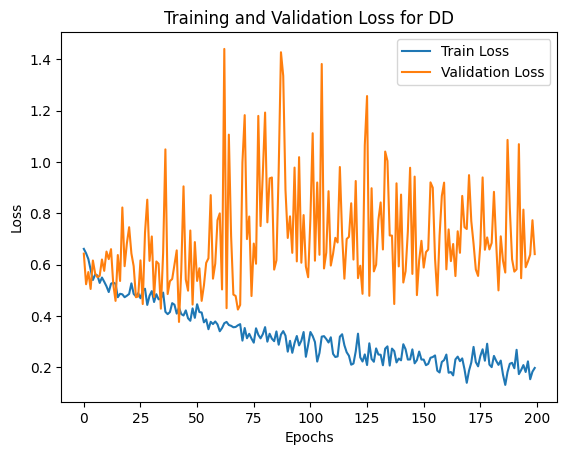

/tmp/ipykernel_30/3914440747.py:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=device))


Model loaded from models/best_model_DD.pth
Test Accuracy: 0.78
Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.80      0.80        65
           1       0.76      0.76      0.76        54

    accuracy                           0.78       119
   macro avg       0.78      0.78      0.78       119
weighted avg       0.78      0.78      0.78       119



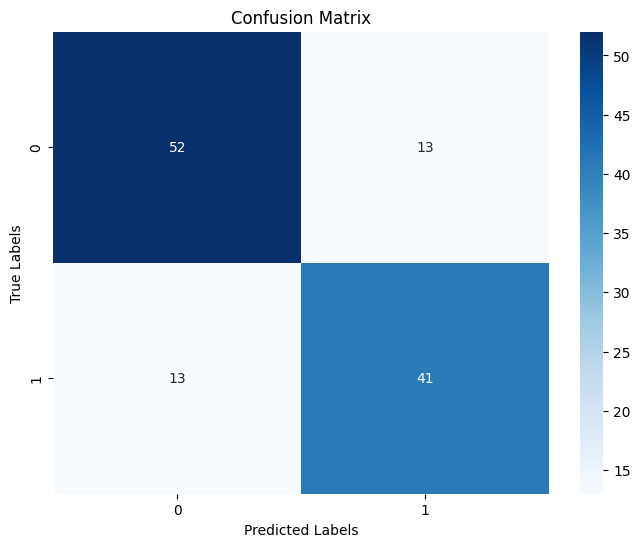

Best Validation Accuracy for DD: 0.84
Test Accuracy for DD: 0.78

Running experiment with k_values: 0.8


  0%|          | 1/200 [00:08<28:22,  8.56s/it]

Epoch:0, Train Loss:0.6969, Train Acc:0.58, Val Loss:0.8257, Val Acc:0.26
Model saved at models/best_model_DD.pth


  1%|          | 2/200 [00:16<27:58,  8.48s/it]

Epoch:1, Train Loss:0.6197, Train Acc:0.70, Val Loss:0.6229, Val Acc:0.68
Model saved at models/best_model_DD.pth


  2%|▏         | 3/200 [00:25<27:36,  8.41s/it]

Epoch:2, Train Loss:0.5859, Train Acc:0.71, Val Loss:0.5502, Val Acc:0.72
Model saved at models/best_model_DD.pth


  2%|▏         | 4/200 [00:33<27:23,  8.38s/it]

Epoch:3, Train Loss:0.5753, Train Acc:0.71, Val Loss:0.5362, Val Acc:0.79
Model saved at models/best_model_DD.pth


  2%|▎         | 5/200 [00:41<27:06,  8.34s/it]

Epoch:4, Train Loss:0.5975, Train Acc:0.70, Val Loss:0.5489, Val Acc:0.82
Model saved at models/best_model_DD.pth


  3%|▎         | 6/200 [00:50<27:15,  8.43s/it]

Epoch:5, Train Loss:0.5722, Train Acc:0.72, Val Loss:0.5754, Val Acc:0.84
Model saved at models/best_model_DD.pth


  4%|▎         | 7/200 [00:58<27:02,  8.41s/it]

Epoch:6, Train Loss:0.5787, Train Acc:0.74, Val Loss:0.5030, Val Acc:0.81


  4%|▍         | 8/200 [01:07<26:53,  8.41s/it]

Epoch:7, Train Loss:0.5495, Train Acc:0.75, Val Loss:0.5374, Val Acc:0.80


  4%|▍         | 9/200 [01:15<26:33,  8.34s/it]

Epoch:8, Train Loss:0.5658, Train Acc:0.73, Val Loss:0.5549, Val Acc:0.78


  5%|▌         | 10/200 [01:24<26:38,  8.41s/it]

Epoch:9, Train Loss:0.5563, Train Acc:0.74, Val Loss:0.5383, Val Acc:0.80


  6%|▌         | 11/200 [01:32<26:26,  8.39s/it]

Epoch:10, Train Loss:0.5588, Train Acc:0.74, Val Loss:0.5182, Val Acc:0.77


  6%|▌         | 12/200 [01:40<26:18,  8.40s/it]

Epoch:11, Train Loss:0.5629, Train Acc:0.76, Val Loss:0.5266, Val Acc:0.76


  6%|▋         | 13/200 [01:48<25:51,  8.29s/it]

Epoch:12, Train Loss:0.5241, Train Acc:0.76, Val Loss:0.4999, Val Acc:0.76


  7%|▋         | 14/200 [01:57<25:43,  8.30s/it]

Epoch:13, Train Loss:0.5203, Train Acc:0.76, Val Loss:0.5269, Val Acc:0.79


  8%|▊         | 15/200 [02:05<25:40,  8.33s/it]

Epoch:14, Train Loss:0.5235, Train Acc:0.75, Val Loss:0.5502, Val Acc:0.73


  8%|▊         | 16/200 [02:13<25:25,  8.29s/it]

Epoch:15, Train Loss:0.5244, Train Acc:0.75, Val Loss:0.4890, Val Acc:0.78


  8%|▊         | 17/200 [02:22<25:31,  8.37s/it]

Epoch:16, Train Loss:0.5188, Train Acc:0.78, Val Loss:0.5260, Val Acc:0.74


  9%|▉         | 18/200 [02:30<25:25,  8.38s/it]

Epoch:17, Train Loss:0.5249, Train Acc:0.76, Val Loss:0.5066, Val Acc:0.79


 10%|▉         | 19/200 [02:39<25:15,  8.37s/it]

Epoch:18, Train Loss:0.5298, Train Acc:0.76, Val Loss:0.4653, Val Acc:0.81


 10%|█         | 20/200 [02:47<25:01,  8.34s/it]

Epoch:19, Train Loss:0.4966, Train Acc:0.79, Val Loss:0.4368, Val Acc:0.81


 10%|█         | 21/200 [02:55<25:01,  8.39s/it]

Epoch:20, Train Loss:0.4805, Train Acc:0.78, Val Loss:0.5971, Val Acc:0.68


 11%|█         | 22/200 [03:04<24:48,  8.36s/it]

Epoch:21, Train Loss:0.4836, Train Acc:0.77, Val Loss:0.5055, Val Acc:0.82


 12%|█▏        | 23/200 [03:12<24:38,  8.35s/it]

Epoch:22, Train Loss:0.5097, Train Acc:0.76, Val Loss:0.4878, Val Acc:0.78


 12%|█▏        | 24/200 [03:20<24:27,  8.34s/it]

Epoch:23, Train Loss:0.4770, Train Acc:0.79, Val Loss:0.5442, Val Acc:0.74


 12%|█▎        | 25/200 [03:29<24:30,  8.41s/it]

Epoch:24, Train Loss:0.5117, Train Acc:0.78, Val Loss:0.4967, Val Acc:0.76


 13%|█▎        | 26/200 [03:37<24:21,  8.40s/it]

Epoch:25, Train Loss:0.4945, Train Acc:0.79, Val Loss:0.4821, Val Acc:0.76


 14%|█▎        | 27/200 [03:46<24:12,  8.40s/it]

Epoch:26, Train Loss:0.4683, Train Acc:0.80, Val Loss:0.4598, Val Acc:0.76


 14%|█▍        | 28/200 [03:54<23:57,  8.36s/it]

Epoch:27, Train Loss:0.4664, Train Acc:0.79, Val Loss:0.4583, Val Acc:0.81


 14%|█▍        | 29/200 [04:02<23:55,  8.39s/it]

Epoch:28, Train Loss:0.4854, Train Acc:0.79, Val Loss:0.6613, Val Acc:0.64


 15%|█▌        | 30/200 [04:11<23:43,  8.37s/it]

Epoch:29, Train Loss:0.4847, Train Acc:0.80, Val Loss:0.6313, Val Acc:0.76


 16%|█▌        | 31/200 [04:19<23:37,  8.39s/it]

Epoch:30, Train Loss:0.4678, Train Acc:0.80, Val Loss:0.4981, Val Acc:0.80


 16%|█▌        | 32/200 [04:28<23:29,  8.39s/it]

Epoch:31, Train Loss:0.4516, Train Acc:0.80, Val Loss:0.5368, Val Acc:0.75


 16%|█▋        | 33/200 [04:36<23:26,  8.42s/it]

Epoch:32, Train Loss:0.4778, Train Acc:0.80, Val Loss:0.6089, Val Acc:0.67


 17%|█▋        | 34/200 [04:44<23:11,  8.38s/it]

Epoch:33, Train Loss:0.4735, Train Acc:0.79, Val Loss:0.6565, Val Acc:0.58


 18%|█▊        | 35/200 [04:52<22:51,  8.31s/it]

Epoch:34, Train Loss:0.4276, Train Acc:0.82, Val Loss:0.5583, Val Acc:0.72


 18%|█▊        | 36/200 [05:01<22:40,  8.30s/it]

Epoch:35, Train Loss:0.4479, Train Acc:0.81, Val Loss:0.5393, Val Acc:0.74


 18%|█▊        | 37/200 [05:09<22:30,  8.29s/it]

Epoch:36, Train Loss:0.4210, Train Acc:0.81, Val Loss:0.7210, Val Acc:0.58


 19%|█▉        | 38/200 [05:17<22:19,  8.27s/it]

Epoch:37, Train Loss:0.4275, Train Acc:0.82, Val Loss:0.6490, Val Acc:0.78


 20%|█▉        | 39/200 [05:25<22:11,  8.27s/it]

Epoch:38, Train Loss:0.4513, Train Acc:0.82, Val Loss:0.5788, Val Acc:0.82


 20%|██        | 40/200 [05:34<22:05,  8.29s/it]

Epoch:39, Train Loss:0.4568, Train Acc:0.81, Val Loss:0.4724, Val Acc:0.80


 20%|██        | 41/200 [05:42<22:01,  8.31s/it]

Epoch:40, Train Loss:0.4580, Train Acc:0.81, Val Loss:0.4958, Val Acc:0.75


 21%|██        | 42/200 [05:51<21:55,  8.33s/it]

Epoch:41, Train Loss:0.4342, Train Acc:0.81, Val Loss:0.4995, Val Acc:0.79


 22%|██▏       | 43/200 [05:59<21:41,  8.29s/it]

Epoch:42, Train Loss:0.4248, Train Acc:0.82, Val Loss:0.5103, Val Acc:0.77


 22%|██▏       | 44/200 [06:07<21:40,  8.34s/it]

Epoch:43, Train Loss:0.4181, Train Acc:0.81, Val Loss:0.6137, Val Acc:0.65


 22%|██▎       | 45/200 [06:15<21:24,  8.29s/it]

Epoch:44, Train Loss:0.4253, Train Acc:0.82, Val Loss:0.6042, Val Acc:0.65


 23%|██▎       | 46/200 [06:24<21:12,  8.26s/it]

Epoch:45, Train Loss:0.4432, Train Acc:0.81, Val Loss:0.5750, Val Acc:0.79


 24%|██▎       | 47/200 [06:32<21:03,  8.26s/it]

Epoch:46, Train Loss:0.4386, Train Acc:0.83, Val Loss:0.5834, Val Acc:0.73


 24%|██▍       | 48/200 [06:40<21:04,  8.32s/it]

Epoch:47, Train Loss:0.4370, Train Acc:0.80, Val Loss:0.5465, Val Acc:0.74


 24%|██▍       | 49/200 [06:49<20:53,  8.30s/it]

Epoch:48, Train Loss:0.4296, Train Acc:0.80, Val Loss:0.5178, Val Acc:0.74


 25%|██▌       | 50/200 [06:57<20:47,  8.32s/it]

Epoch:49, Train Loss:0.3782, Train Acc:0.84, Val Loss:0.5581, Val Acc:0.75


 26%|██▌       | 51/200 [07:05<20:40,  8.33s/it]

Epoch:50, Train Loss:0.4131, Train Acc:0.84, Val Loss:0.5971, Val Acc:0.68


 26%|██▌       | 52/200 [07:14<20:36,  8.35s/it]

Epoch:51, Train Loss:0.4272, Train Acc:0.82, Val Loss:0.5601, Val Acc:0.76


 26%|██▋       | 53/200 [07:22<20:25,  8.34s/it]

Epoch:52, Train Loss:0.4079, Train Acc:0.83, Val Loss:0.6337, Val Acc:0.63


 27%|██▋       | 54/200 [07:30<20:13,  8.31s/it]

Epoch:53, Train Loss:0.4363, Train Acc:0.83, Val Loss:0.6600, Val Acc:0.64


 28%|██▊       | 55/200 [07:39<20:08,  8.34s/it]

Epoch:54, Train Loss:0.4121, Train Acc:0.84, Val Loss:0.6048, Val Acc:0.69


 28%|██▊       | 56/200 [07:47<20:12,  8.42s/it]

Epoch:55, Train Loss:0.4476, Train Acc:0.80, Val Loss:0.5111, Val Acc:0.80


 28%|██▊       | 57/200 [07:55<19:56,  8.37s/it]

Epoch:56, Train Loss:0.3997, Train Acc:0.83, Val Loss:0.5085, Val Acc:0.78


 29%|██▉       | 58/200 [08:04<19:51,  8.39s/it]

Epoch:57, Train Loss:0.4095, Train Acc:0.84, Val Loss:0.5354, Val Acc:0.78


 30%|██▉       | 59/200 [08:12<19:47,  8.42s/it]

Epoch:58, Train Loss:0.3997, Train Acc:0.82, Val Loss:0.5410, Val Acc:0.77


 30%|███       | 60/200 [08:21<19:33,  8.38s/it]

Epoch:59, Train Loss:0.3988, Train Acc:0.84, Val Loss:0.5065, Val Acc:0.79


 30%|███       | 61/200 [08:29<19:26,  8.39s/it]

Epoch:60, Train Loss:0.3991, Train Acc:0.85, Val Loss:0.5225, Val Acc:0.79


 31%|███       | 62/200 [08:37<19:11,  8.34s/it]

Epoch:61, Train Loss:0.4148, Train Acc:0.82, Val Loss:0.6843, Val Acc:0.79


 32%|███▏      | 63/200 [08:46<18:59,  8.32s/it]

Epoch:62, Train Loss:0.3891, Train Acc:0.83, Val Loss:0.7091, Val Acc:0.65


 32%|███▏      | 64/200 [08:54<18:56,  8.35s/it]

Epoch:63, Train Loss:0.3484, Train Acc:0.85, Val Loss:0.8242, Val Acc:0.63


 32%|███▎      | 65/200 [09:02<18:43,  8.32s/it]

Epoch:64, Train Loss:0.3669, Train Acc:0.85, Val Loss:0.5571, Val Acc:0.77


 33%|███▎      | 66/200 [09:11<18:41,  8.37s/it]

Epoch:65, Train Loss:0.3665, Train Acc:0.84, Val Loss:0.4779, Val Acc:0.78


 34%|███▎      | 67/200 [09:19<18:37,  8.40s/it]

Epoch:66, Train Loss:0.3844, Train Acc:0.85, Val Loss:0.5546, Val Acc:0.80


 34%|███▍      | 68/200 [09:28<18:27,  8.39s/it]

Epoch:67, Train Loss:0.3750, Train Acc:0.83, Val Loss:0.7119, Val Acc:0.79


 34%|███▍      | 69/200 [09:36<18:19,  8.39s/it]

Epoch:68, Train Loss:0.3930, Train Acc:0.85, Val Loss:0.5889, Val Acc:0.78


 35%|███▌      | 70/200 [09:44<18:14,  8.42s/it]

Epoch:69, Train Loss:0.3722, Train Acc:0.86, Val Loss:0.6207, Val Acc:0.75


 36%|███▌      | 71/200 [09:53<18:04,  8.40s/it]

Epoch:70, Train Loss:0.3900, Train Acc:0.85, Val Loss:0.8407, Val Acc:0.64


 36%|███▌      | 72/200 [10:01<17:57,  8.42s/it]

Epoch:71, Train Loss:0.3308, Train Acc:0.86, Val Loss:0.7378, Val Acc:0.65


 36%|███▋      | 73/200 [10:10<17:41,  8.35s/it]

Epoch:72, Train Loss:0.3631, Train Acc:0.85, Val Loss:0.8561, Val Acc:0.63


 37%|███▋      | 74/200 [10:18<17:36,  8.38s/it]

Epoch:73, Train Loss:0.3333, Train Acc:0.85, Val Loss:0.6786, Val Acc:0.67


 38%|███▊      | 75/200 [10:26<17:30,  8.41s/it]

Epoch:74, Train Loss:0.3315, Train Acc:0.85, Val Loss:0.4890, Val Acc:0.79


 38%|███▊      | 76/200 [10:35<17:20,  8.39s/it]

Epoch:75, Train Loss:0.3726, Train Acc:0.85, Val Loss:0.6220, Val Acc:0.77


 38%|███▊      | 77/200 [10:43<16:49,  8.21s/it]

Epoch:76, Train Loss:0.3411, Train Acc:0.86, Val Loss:0.6763, Val Acc:0.75


 39%|███▉      | 78/200 [10:51<16:50,  8.29s/it]

Epoch:77, Train Loss:0.3575, Train Acc:0.86, Val Loss:0.8853, Val Acc:0.68


 40%|███▉      | 79/200 [11:00<16:50,  8.35s/it]

Epoch:78, Train Loss:0.3613, Train Acc:0.85, Val Loss:0.5018, Val Acc:0.80


 40%|████      | 80/200 [11:08<16:45,  8.38s/it]

Epoch:79, Train Loss:0.3743, Train Acc:0.86, Val Loss:0.6019, Val Acc:0.76


 40%|████      | 81/200 [11:16<16:38,  8.39s/it]

Epoch:80, Train Loss:0.3484, Train Acc:0.87, Val Loss:0.5858, Val Acc:0.76


 41%|████      | 82/200 [11:25<16:25,  8.35s/it]

Epoch:81, Train Loss:0.3586, Train Acc:0.86, Val Loss:0.4752, Val Acc:0.76


 42%|████▏     | 83/200 [11:33<16:17,  8.35s/it]

Epoch:82, Train Loss:0.3627, Train Acc:0.86, Val Loss:0.7851, Val Acc:0.70


 42%|████▏     | 84/200 [11:41<16:09,  8.36s/it]

Epoch:83, Train Loss:0.3205, Train Acc:0.88, Val Loss:0.6958, Val Acc:0.74


 42%|████▎     | 85/200 [11:50<15:56,  8.31s/it]

Epoch:84, Train Loss:0.3007, Train Acc:0.87, Val Loss:0.8042, Val Acc:0.68


 43%|████▎     | 86/200 [11:58<15:55,  8.38s/it]

Epoch:85, Train Loss:0.2979, Train Acc:0.87, Val Loss:0.7556, Val Acc:0.66


 44%|████▎     | 87/200 [12:06<15:45,  8.37s/it]

Epoch:86, Train Loss:0.3590, Train Acc:0.85, Val Loss:0.5195, Val Acc:0.82


 44%|████▍     | 88/200 [12:15<15:36,  8.36s/it]

Epoch:87, Train Loss:0.3111, Train Acc:0.88, Val Loss:0.5564, Val Acc:0.79


 44%|████▍     | 89/200 [12:23<15:30,  8.38s/it]

Epoch:88, Train Loss:0.3299, Train Acc:0.86, Val Loss:0.9401, Val Acc:0.62


 45%|████▌     | 90/200 [12:32<15:22,  8.39s/it]

Epoch:89, Train Loss:0.3582, Train Acc:0.86, Val Loss:0.4881, Val Acc:0.76


 46%|████▌     | 91/200 [12:40<15:11,  8.37s/it]

Epoch:90, Train Loss:0.3412, Train Acc:0.87, Val Loss:0.6424, Val Acc:0.73


 46%|████▌     | 92/200 [12:48<15:07,  8.40s/it]

Epoch:91, Train Loss:0.3089, Train Acc:0.87, Val Loss:0.4858, Val Acc:0.78


 46%|████▋     | 93/200 [12:57<14:52,  8.35s/it]

Epoch:92, Train Loss:0.3603, Train Acc:0.86, Val Loss:0.6809, Val Acc:0.75


 47%|████▋     | 94/200 [13:05<14:54,  8.44s/it]

Epoch:93, Train Loss:0.3130, Train Acc:0.89, Val Loss:0.7006, Val Acc:0.74


 48%|████▊     | 95/200 [13:14<14:45,  8.43s/it]

Epoch:94, Train Loss:0.3138, Train Acc:0.88, Val Loss:0.9118, Val Acc:0.62


 48%|████▊     | 96/200 [13:22<14:28,  8.35s/it]

Epoch:95, Train Loss:0.2969, Train Acc:0.87, Val Loss:0.9024, Val Acc:0.69


 48%|████▊     | 97/200 [13:30<14:23,  8.39s/it]

Epoch:96, Train Loss:0.2833, Train Acc:0.88, Val Loss:0.6124, Val Acc:0.80


 49%|████▉     | 98/200 [13:39<14:18,  8.41s/it]

Epoch:97, Train Loss:0.2792, Train Acc:0.88, Val Loss:0.8122, Val Acc:0.74


 50%|████▉     | 99/200 [13:47<14:05,  8.37s/it]

Epoch:98, Train Loss:0.3142, Train Acc:0.89, Val Loss:1.0108, Val Acc:0.64


 50%|█████     | 100/200 [13:55<13:54,  8.35s/it]

Epoch:99, Train Loss:0.3255, Train Acc:0.86, Val Loss:0.6205, Val Acc:0.73


 50%|█████     | 101/200 [14:04<13:50,  8.38s/it]

Epoch:100, Train Loss:0.3532, Train Acc:0.86, Val Loss:0.6626, Val Acc:0.73


 51%|█████     | 102/200 [14:12<13:43,  8.40s/it]

Epoch:101, Train Loss:0.2878, Train Acc:0.88, Val Loss:0.9913, Val Acc:0.60


 52%|█████▏    | 103/200 [14:21<13:35,  8.41s/it]

Epoch:102, Train Loss:0.2811, Train Acc:0.90, Val Loss:0.8630, Val Acc:0.71


 52%|█████▏    | 104/200 [14:29<13:26,  8.40s/it]

Epoch:103, Train Loss:0.2518, Train Acc:0.89, Val Loss:0.6231, Val Acc:0.74


 52%|█████▎    | 105/200 [14:38<13:21,  8.44s/it]

Epoch:104, Train Loss:0.2363, Train Acc:0.90, Val Loss:0.8069, Val Acc:0.65


 53%|█████▎    | 106/200 [14:46<13:08,  8.39s/it]

Epoch:105, Train Loss:0.3229, Train Acc:0.88, Val Loss:1.2818, Val Acc:0.50


 54%|█████▎    | 107/200 [14:54<12:54,  8.33s/it]

Epoch:106, Train Loss:0.2883, Train Acc:0.90, Val Loss:0.5124, Val Acc:0.77


 54%|█████▍    | 108/200 [15:02<12:45,  8.32s/it]

Epoch:107, Train Loss:0.3231, Train Acc:0.87, Val Loss:0.9915, Val Acc:0.51


 55%|█████▍    | 109/200 [15:11<12:39,  8.35s/it]

Epoch:108, Train Loss:0.2804, Train Acc:0.89, Val Loss:0.7929, Val Acc:0.66


 56%|█████▌    | 111/200 [15:28<12:25,  8.37s/it]

Epoch:110, Train Loss:0.3106, Train Acc:0.89, Val Loss:0.6215, Val Acc:0.76


 56%|█████▌    | 112/200 [15:36<12:17,  8.38s/it]

Epoch:111, Train Loss:0.2866, Train Acc:0.89, Val Loss:0.6975, Val Acc:0.74


 56%|█████▋    | 113/200 [15:44<12:10,  8.40s/it]

Epoch:112, Train Loss:0.2957, Train Acc:0.89, Val Loss:0.5321, Val Acc:0.78


 57%|█████▋    | 114/200 [15:53<12:04,  8.42s/it]

Epoch:113, Train Loss:0.3012, Train Acc:0.88, Val Loss:0.8233, Val Acc:0.69


 57%|█████▊    | 115/200 [16:01<11:54,  8.40s/it]

Epoch:114, Train Loss:0.2677, Train Acc:0.88, Val Loss:0.7114, Val Acc:0.74


 58%|█████▊    | 116/200 [16:10<11:47,  8.42s/it]

Epoch:115, Train Loss:0.2443, Train Acc:0.90, Val Loss:0.8148, Val Acc:0.68


 58%|█████▊    | 117/200 [16:18<11:37,  8.41s/it]

Epoch:116, Train Loss:0.2520, Train Acc:0.89, Val Loss:0.7461, Val Acc:0.75


 59%|█████▉    | 118/200 [16:26<11:27,  8.38s/it]

Epoch:117, Train Loss:0.2360, Train Acc:0.89, Val Loss:0.5655, Val Acc:0.79


 60%|█████▉    | 119/200 [16:35<11:18,  8.38s/it]

Epoch:118, Train Loss:0.2771, Train Acc:0.90, Val Loss:0.8936, Val Acc:0.68


 60%|██████    | 120/200 [16:43<11:08,  8.36s/it]

Epoch:119, Train Loss:0.2751, Train Acc:0.92, Val Loss:1.0362, Val Acc:0.65


 60%|██████    | 121/200 [16:52<11:05,  8.42s/it]

Epoch:120, Train Loss:0.2961, Train Acc:0.89, Val Loss:0.6762, Val Acc:0.73


 61%|██████    | 122/200 [17:00<10:56,  8.42s/it]

Epoch:121, Train Loss:0.2845, Train Acc:0.90, Val Loss:0.8863, Val Acc:0.74


 62%|██████▏   | 123/200 [17:08<10:43,  8.36s/it]

Epoch:122, Train Loss:0.2818, Train Acc:0.89, Val Loss:0.7996, Val Acc:0.64


 62%|██████▏   | 124/200 [17:17<10:36,  8.37s/it]

Epoch:123, Train Loss:0.2894, Train Acc:0.91, Val Loss:0.7072, Val Acc:0.71


 62%|██████▎   | 125/200 [17:25<10:26,  8.36s/it]

Epoch:124, Train Loss:0.2008, Train Acc:0.92, Val Loss:1.0005, Val Acc:0.62


 63%|██████▎   | 126/200 [17:33<10:18,  8.36s/it]

Epoch:125, Train Loss:0.2576, Train Acc:0.89, Val Loss:0.8545, Val Acc:0.69


 64%|██████▎   | 127/200 [17:42<10:05,  8.30s/it]

Epoch:126, Train Loss:0.2250, Train Acc:0.92, Val Loss:0.5101, Val Acc:0.79


 64%|██████▍   | 128/200 [17:50<10:01,  8.36s/it]

Epoch:127, Train Loss:0.2199, Train Acc:0.90, Val Loss:1.3125, Val Acc:0.58


 64%|██████▍   | 129/200 [17:59<09:56,  8.40s/it]

Epoch:128, Train Loss:0.2131, Train Acc:0.91, Val Loss:1.1305, Val Acc:0.57


 65%|██████▌   | 130/200 [18:07<09:49,  8.42s/it]

Epoch:129, Train Loss:0.2427, Train Acc:0.90, Val Loss:0.6468, Val Acc:0.73


 66%|██████▌   | 131/200 [18:15<09:38,  8.38s/it]

Epoch:130, Train Loss:0.2555, Train Acc:0.90, Val Loss:0.6441, Val Acc:0.73


 66%|██████▌   | 132/200 [18:24<09:33,  8.44s/it]

Epoch:131, Train Loss:0.2851, Train Acc:0.90, Val Loss:0.6930, Val Acc:0.74


 66%|██████▋   | 133/200 [18:32<09:13,  8.26s/it]

Epoch:132, Train Loss:0.2489, Train Acc:0.92, Val Loss:1.0978, Val Acc:0.60


 67%|██████▋   | 134/200 [18:40<09:00,  8.18s/it]

Epoch:133, Train Loss:0.2750, Train Acc:0.91, Val Loss:0.8298, Val Acc:0.61


 68%|██████▊   | 135/200 [18:48<08:50,  8.16s/it]

Epoch:134, Train Loss:0.2292, Train Acc:0.91, Val Loss:0.8741, Val Acc:0.72


 68%|██████▊   | 136/200 [18:56<08:50,  8.29s/it]

Epoch:135, Train Loss:0.2573, Train Acc:0.92, Val Loss:0.5577, Val Acc:0.77


 68%|██████▊   | 137/200 [19:05<08:44,  8.32s/it]

Epoch:136, Train Loss:0.2298, Train Acc:0.91, Val Loss:0.4999, Val Acc:0.79


 69%|██████▉   | 138/200 [19:13<08:36,  8.32s/it]

Epoch:137, Train Loss:0.2496, Train Acc:0.91, Val Loss:0.6973, Val Acc:0.78


 70%|██████▉   | 139/200 [19:21<08:26,  8.30s/it]

Epoch:138, Train Loss:0.2314, Train Acc:0.92, Val Loss:0.7209, Val Acc:0.71


 70%|███████   | 140/200 [19:30<08:22,  8.37s/it]

Epoch:139, Train Loss:0.2376, Train Acc:0.90, Val Loss:0.6254, Val Acc:0.76


 70%|███████   | 141/200 [19:38<08:14,  8.38s/it]

Epoch:140, Train Loss:0.2088, Train Acc:0.91, Val Loss:0.9053, Val Acc:0.65


 71%|███████   | 142/200 [19:47<08:03,  8.34s/it]

Epoch:141, Train Loss:0.2281, Train Acc:0.91, Val Loss:0.9093, Val Acc:0.63


 72%|███████▏  | 143/200 [19:55<07:59,  8.42s/it]

Epoch:142, Train Loss:0.2913, Train Acc:0.90, Val Loss:0.9493, Val Acc:0.62


 72%|███████▏  | 144/200 [20:04<07:52,  8.45s/it]

Epoch:143, Train Loss:0.2245, Train Acc:0.91, Val Loss:0.6390, Val Acc:0.75


 72%|███████▎  | 145/200 [20:12<07:42,  8.41s/it]

Epoch:144, Train Loss:0.2552, Train Acc:0.92, Val Loss:0.6214, Val Acc:0.77


 73%|███████▎  | 146/200 [20:20<07:33,  8.39s/it]

Epoch:145, Train Loss:0.1872, Train Acc:0.92, Val Loss:0.7817, Val Acc:0.78


 74%|███████▎  | 147/200 [20:29<07:23,  8.36s/it]

Epoch:146, Train Loss:0.3064, Train Acc:0.89, Val Loss:0.7892, Val Acc:0.78


 74%|███████▍  | 148/200 [20:37<07:14,  8.36s/it]

Epoch:147, Train Loss:0.2194, Train Acc:0.93, Val Loss:0.8809, Val Acc:0.68


 74%|███████▍  | 149/200 [20:45<07:03,  8.30s/it]

Epoch:148, Train Loss:0.2514, Train Acc:0.92, Val Loss:0.9159, Val Acc:0.71


 75%|███████▌  | 150/200 [20:54<06:57,  8.36s/it]

Epoch:149, Train Loss:0.2062, Train Acc:0.92, Val Loss:1.3434, Val Acc:0.53


 76%|███████▌  | 151/200 [21:02<06:51,  8.40s/it]

Epoch:150, Train Loss:0.2251, Train Acc:0.93, Val Loss:1.4293, Val Acc:0.51


 76%|███████▌  | 152/200 [21:10<06:38,  8.30s/it]

Epoch:151, Train Loss:0.2156, Train Acc:0.94, Val Loss:1.1302, Val Acc:0.57


 76%|███████▋  | 153/200 [21:19<06:32,  8.34s/it]

Epoch:152, Train Loss:0.2426, Train Acc:0.91, Val Loss:0.5030, Val Acc:0.79


 77%|███████▋  | 154/200 [21:27<06:25,  8.39s/it]

Epoch:153, Train Loss:0.1665, Train Acc:0.93, Val Loss:0.8145, Val Acc:0.65


 78%|███████▊  | 155/200 [21:36<06:20,  8.45s/it]

Epoch:154, Train Loss:0.2512, Train Acc:0.91, Val Loss:0.6854, Val Acc:0.77


 78%|███████▊  | 156/200 [21:44<06:09,  8.39s/it]

Epoch:155, Train Loss:0.2325, Train Acc:0.93, Val Loss:0.7696, Val Acc:0.76


 78%|███████▊  | 157/200 [21:52<06:01,  8.41s/it]

Epoch:156, Train Loss:0.2621, Train Acc:0.93, Val Loss:1.0976, Val Acc:0.68


 79%|███████▉  | 158/200 [22:01<05:55,  8.45s/it]

Epoch:157, Train Loss:0.2355, Train Acc:0.92, Val Loss:0.8130, Val Acc:0.66


 80%|███████▉  | 159/200 [22:10<05:47,  8.47s/it]

Epoch:158, Train Loss:0.1822, Train Acc:0.93, Val Loss:0.9630, Val Acc:0.59


 80%|████████  | 160/200 [22:18<05:39,  8.49s/it]

Epoch:159, Train Loss:0.2889, Train Acc:0.90, Val Loss:0.7706, Val Acc:0.74


 80%|████████  | 161/200 [22:27<05:30,  8.48s/it]

Epoch:160, Train Loss:0.2738, Train Acc:0.91, Val Loss:0.5598, Val Acc:0.80


 81%|████████  | 162/200 [22:35<05:22,  8.48s/it]

Epoch:161, Train Loss:0.2221, Train Acc:0.93, Val Loss:1.0845, Val Acc:0.73


 82%|████████▏ | 163/200 [22:44<05:14,  8.50s/it]

Epoch:162, Train Loss:0.1900, Train Acc:0.92, Val Loss:1.1840, Val Acc:0.62


 82%|████████▏ | 164/200 [22:52<05:03,  8.44s/it]

Epoch:163, Train Loss:0.2303, Train Acc:0.93, Val Loss:0.7920, Val Acc:0.70


 82%|████████▎ | 165/200 [23:00<04:56,  8.46s/it]

Epoch:164, Train Loss:0.2594, Train Acc:0.90, Val Loss:1.1582, Val Acc:0.58


 83%|████████▎ | 166/200 [23:09<04:48,  8.47s/it]

Epoch:165, Train Loss:0.1920, Train Acc:0.93, Val Loss:1.1530, Val Acc:0.60


 84%|████████▎ | 167/200 [23:17<04:39,  8.48s/it]

Epoch:166, Train Loss:0.2276, Train Acc:0.92, Val Loss:0.7937, Val Acc:0.75


 84%|████████▍ | 168/200 [23:26<04:31,  8.49s/it]

Epoch:167, Train Loss:0.2344, Train Acc:0.91, Val Loss:0.6049, Val Acc:0.79


 84%|████████▍ | 169/200 [23:34<04:23,  8.49s/it]

Epoch:168, Train Loss:0.1724, Train Acc:0.93, Val Loss:0.7386, Val Acc:0.76


 85%|████████▌ | 170/200 [23:43<04:14,  8.50s/it]

Epoch:169, Train Loss:0.1978, Train Acc:0.92, Val Loss:0.7580, Val Acc:0.77


 86%|████████▌ | 171/200 [23:51<04:05,  8.48s/it]

Epoch:170, Train Loss:0.2650, Train Acc:0.91, Val Loss:0.7526, Val Acc:0.76


 86%|████████▌ | 172/200 [24:00<03:56,  8.45s/it]

Epoch:171, Train Loss:0.1960, Train Acc:0.93, Val Loss:0.8988, Val Acc:0.71


 86%|████████▋ | 173/200 [24:08<03:43,  8.27s/it]

Epoch:172, Train Loss:0.2429, Train Acc:0.92, Val Loss:1.1479, Val Acc:0.66


 87%|████████▋ | 174/200 [24:16<03:38,  8.39s/it]

Epoch:173, Train Loss:0.2048, Train Acc:0.94, Val Loss:0.9059, Val Acc:0.61


 88%|████████▊ | 175/200 [24:25<03:29,  8.39s/it]

Epoch:174, Train Loss:0.2146, Train Acc:0.93, Val Loss:1.7185, Val Acc:0.47


 88%|████████▊ | 176/200 [24:33<03:22,  8.43s/it]

Epoch:175, Train Loss:0.2062, Train Acc:0.93, Val Loss:0.9193, Val Acc:0.67


 88%|████████▊ | 177/200 [24:41<03:13,  8.40s/it]

Epoch:176, Train Loss:0.2315, Train Acc:0.94, Val Loss:0.7238, Val Acc:0.77


 89%|████████▉ | 178/200 [24:50<03:06,  8.47s/it]

Epoch:177, Train Loss:0.1832, Train Acc:0.93, Val Loss:0.6905, Val Acc:0.76


 90%|████████▉ | 179/200 [24:58<02:57,  8.43s/it]

Epoch:178, Train Loss:0.2147, Train Acc:0.93, Val Loss:0.8118, Val Acc:0.75


 90%|█████████ | 180/200 [25:06<02:44,  8.22s/it]

Epoch:179, Train Loss:0.1748, Train Acc:0.93, Val Loss:0.9917, Val Acc:0.67


 90%|█████████ | 181/200 [25:14<02:36,  8.24s/it]

Epoch:180, Train Loss:0.2287, Train Acc:0.92, Val Loss:0.7595, Val Acc:0.77


 91%|█████████ | 182/200 [25:23<02:29,  8.31s/it]

Epoch:181, Train Loss:0.2063, Train Acc:0.93, Val Loss:0.7884, Val Acc:0.78


 92%|█████████▏| 183/200 [25:31<02:21,  8.34s/it]

Epoch:182, Train Loss:0.1748, Train Acc:0.94, Val Loss:0.6629, Val Acc:0.77


 92%|█████████▏| 184/200 [25:40<02:13,  8.36s/it]

Epoch:183, Train Loss:0.1990, Train Acc:0.94, Val Loss:0.5918, Val Acc:0.79


 92%|█████████▎| 185/200 [25:48<02:06,  8.42s/it]

Epoch:184, Train Loss:0.2654, Train Acc:0.92, Val Loss:1.0209, Val Acc:0.65


 93%|█████████▎| 186/200 [25:57<01:57,  8.38s/it]

Epoch:185, Train Loss:0.2752, Train Acc:0.92, Val Loss:0.8067, Val Acc:0.77


 94%|█████████▎| 187/200 [26:05<01:49,  8.40s/it]

Epoch:186, Train Loss:0.2232, Train Acc:0.94, Val Loss:0.7326, Val Acc:0.79


 94%|█████████▍| 188/200 [26:13<01:40,  8.39s/it]

Epoch:187, Train Loss:0.2182, Train Acc:0.93, Val Loss:0.9717, Val Acc:0.77


 94%|█████████▍| 189/200 [26:22<01:32,  8.44s/it]

Epoch:188, Train Loss:0.2072, Train Acc:0.95, Val Loss:0.8990, Val Acc:0.74


 95%|█████████▌| 190/200 [26:30<01:24,  8.46s/it]

Epoch:189, Train Loss:0.1639, Train Acc:0.94, Val Loss:0.8041, Val Acc:0.79


 96%|█████████▌| 191/200 [26:39<01:16,  8.48s/it]

Epoch:190, Train Loss:0.1809, Train Acc:0.93, Val Loss:0.9828, Val Acc:0.72


 96%|█████████▌| 192/200 [26:47<01:07,  8.48s/it]

Epoch:191, Train Loss:0.1895, Train Acc:0.92, Val Loss:0.9035, Val Acc:0.78


 96%|█████████▋| 193/200 [26:56<00:59,  8.50s/it]

Epoch:192, Train Loss:0.2710, Train Acc:0.93, Val Loss:0.8296, Val Acc:0.78


 97%|█████████▋| 194/200 [27:04<00:51,  8.51s/it]

Epoch:193, Train Loss:0.2047, Train Acc:0.92, Val Loss:0.7986, Val Acc:0.66


 98%|█████████▊| 195/200 [27:13<00:42,  8.51s/it]

Epoch:194, Train Loss:0.1480, Train Acc:0.94, Val Loss:0.8537, Val Acc:0.74


 98%|█████████▊| 196/200 [27:22<00:34,  8.51s/it]

Epoch:195, Train Loss:0.2316, Train Acc:0.94, Val Loss:0.5302, Val Acc:0.79


 98%|█████████▊| 197/200 [27:30<00:25,  8.55s/it]

Epoch:196, Train Loss:0.1879, Train Acc:0.92, Val Loss:0.6708, Val Acc:0.79


 99%|█████████▉| 198/200 [27:39<00:17,  8.52s/it]

Epoch:197, Train Loss:0.2188, Train Acc:0.93, Val Loss:0.8861, Val Acc:0.72


100%|█████████▉| 199/200 [27:47<00:08,  8.51s/it]

Epoch:198, Train Loss:0.1662, Train Acc:0.94, Val Loss:0.8301, Val Acc:0.77


100%|██████████| 200/200 [27:56<00:00,  8.38s/it]

Epoch:199, Train Loss:0.2082, Train Acc:0.94, Val Loss:0.9037, Val Acc:0.73


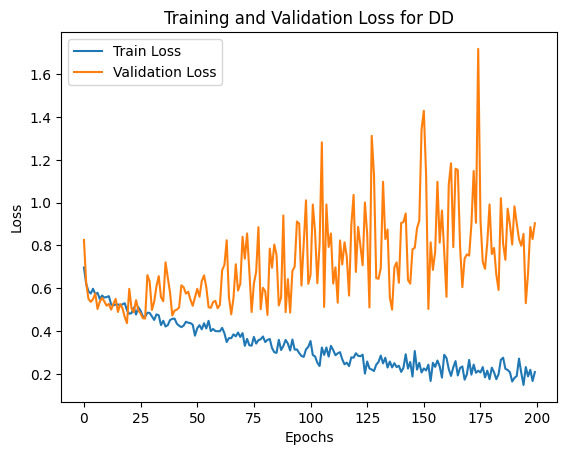

/tmp/ipykernel_30/3914440747.py:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=device))


Model loaded from models/best_model_DD.pth
Test Accuracy: 0.74
Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.87      0.80        70
           1       0.75      0.55      0.64        49

    accuracy                           0.74       119
   macro avg       0.74      0.71      0.72       119
weighted avg       0.74      0.74      0.73       119



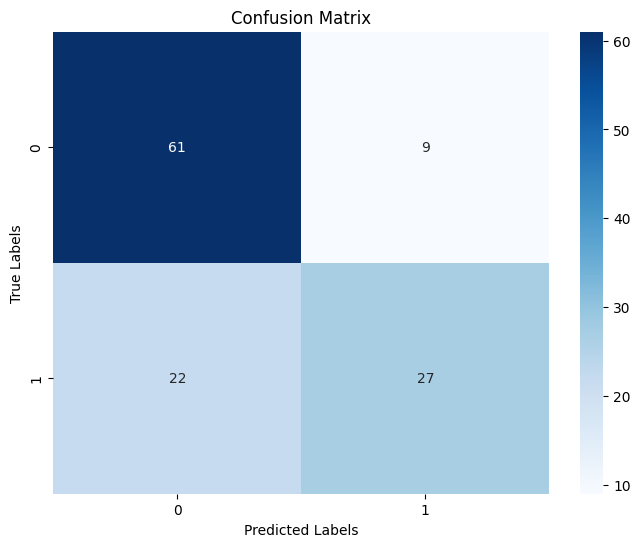

Best Validation Accuracy for DD: 0.84
Test Accuracy for DD: 0.74

Running experiment with k_values: 0.6


  0%|          | 1/200 [00:08<27:39,  8.34s/it]

Epoch:0, Train Loss:0.7274, Train Acc:0.63, Val Loss:1.1688, Val Acc:0.34
Model saved at models/best_model_DD.pth


  1%|          | 2/200 [00:16<27:35,  8.36s/it]

Epoch:1, Train Loss:0.6038, Train Acc:0.72, Val Loss:0.5651, Val Acc:0.77
Model saved at models/best_model_DD.pth


  2%|▏         | 3/200 [00:25<27:32,  8.39s/it]

Epoch:2, Train Loss:0.5515, Train Acc:0.73, Val Loss:0.5116, Val Acc:0.76


  2%|▏         | 4/200 [00:33<27:21,  8.37s/it]

Epoch:3, Train Loss:0.5524, Train Acc:0.73, Val Loss:0.5232, Val Acc:0.75


  2%|▎         | 5/200 [00:41<27:14,  8.38s/it]

Epoch:4, Train Loss:0.5424, Train Acc:0.75, Val Loss:0.5289, Val Acc:0.81
Model saved at models/best_model_DD.pth


  3%|▎         | 6/200 [00:50<27:04,  8.38s/it]

Epoch:5, Train Loss:0.5334, Train Acc:0.76, Val Loss:0.5833, Val Acc:0.72


  4%|▎         | 7/200 [00:58<26:48,  8.33s/it]

Epoch:6, Train Loss:0.5121, Train Acc:0.75, Val Loss:0.5299, Val Acc:0.78


  4%|▍         | 8/200 [01:06<26:36,  8.32s/it]

Epoch:7, Train Loss:0.4979, Train Acc:0.78, Val Loss:0.5112, Val Acc:0.79


  4%|▍         | 9/200 [01:15<26:29,  8.32s/it]

Epoch:8, Train Loss:0.5269, Train Acc:0.76, Val Loss:0.5261, Val Acc:0.78


  5%|▌         | 10/200 [01:23<26:13,  8.28s/it]

Epoch:9, Train Loss:0.4913, Train Acc:0.78, Val Loss:0.5141, Val Acc:0.77


  6%|▌         | 11/200 [01:31<26:17,  8.35s/it]

Epoch:10, Train Loss:0.4910, Train Acc:0.77, Val Loss:0.5307, Val Acc:0.79


  6%|▌         | 12/200 [01:40<26:13,  8.37s/it]

Epoch:11, Train Loss:0.4992, Train Acc:0.78, Val Loss:0.5014, Val Acc:0.78


  6%|▋         | 13/200 [01:48<26:05,  8.37s/it]

Epoch:12, Train Loss:0.4959, Train Acc:0.77, Val Loss:0.5131, Val Acc:0.79


  7%|▋         | 14/200 [01:56<25:45,  8.31s/it]

Epoch:13, Train Loss:0.4948, Train Acc:0.78, Val Loss:0.4895, Val Acc:0.79


  8%|▊         | 15/200 [02:04<25:30,  8.27s/it]

Epoch:14, Train Loss:0.4776, Train Acc:0.76, Val Loss:0.5283, Val Acc:0.80


  8%|▊         | 16/200 [02:13<25:42,  8.38s/it]

Epoch:15, Train Loss:0.4935, Train Acc:0.80, Val Loss:0.4972, Val Acc:0.81


  8%|▊         | 17/200 [02:21<25:23,  8.33s/it]

Epoch:16, Train Loss:0.4703, Train Acc:0.79, Val Loss:0.5201, Val Acc:0.82
Model saved at models/best_model_DD.pth


  9%|▉         | 18/200 [02:30<25:11,  8.30s/it]

Epoch:17, Train Loss:0.4554, Train Acc:0.79, Val Loss:0.4839, Val Acc:0.83
Model saved at models/best_model_DD.pth


 10%|▉         | 19/200 [02:38<24:58,  8.28s/it]

Epoch:18, Train Loss:0.4735, Train Acc:0.78, Val Loss:0.5110, Val Acc:0.81


 10%|█         | 20/200 [02:46<24:53,  8.30s/it]

Epoch:19, Train Loss:0.4488, Train Acc:0.80, Val Loss:0.4920, Val Acc:0.81


 10%|█         | 21/200 [02:54<24:37,  8.26s/it]

Epoch:20, Train Loss:0.5103, Train Acc:0.79, Val Loss:0.5140, Val Acc:0.81


 11%|█         | 22/200 [03:03<24:38,  8.31s/it]

Epoch:21, Train Loss:0.4534, Train Acc:0.81, Val Loss:0.5471, Val Acc:0.71


 12%|█▏        | 23/200 [03:11<24:38,  8.35s/it]

Epoch:22, Train Loss:0.4592, Train Acc:0.80, Val Loss:0.5021, Val Acc:0.82


 12%|█▏        | 24/200 [03:20<24:31,  8.36s/it]

Epoch:23, Train Loss:0.4342, Train Acc:0.81, Val Loss:0.4689, Val Acc:0.80


 12%|█▎        | 25/200 [03:28<24:19,  8.34s/it]

Epoch:24, Train Loss:0.4056, Train Acc:0.83, Val Loss:0.5154, Val Acc:0.73


 13%|█▎        | 26/200 [03:36<24:06,  8.31s/it]

Epoch:25, Train Loss:0.4331, Train Acc:0.80, Val Loss:0.4787, Val Acc:0.84
Model saved at models/best_model_DD.pth


 14%|█▎        | 27/200 [03:45<24:10,  8.38s/it]

Epoch:26, Train Loss:0.4567, Train Acc:0.81, Val Loss:0.5100, Val Acc:0.77


 14%|█▍        | 28/200 [03:53<24:05,  8.40s/it]

Epoch:27, Train Loss:0.4405, Train Acc:0.81, Val Loss:0.4326, Val Acc:0.81


 14%|█▍        | 29/200 [04:01<23:46,  8.34s/it]

Epoch:28, Train Loss:0.4717, Train Acc:0.81, Val Loss:0.4449, Val Acc:0.85
Model saved at models/best_model_DD.pth


 15%|█▌        | 30/200 [04:10<23:41,  8.36s/it]

Epoch:29, Train Loss:0.4323, Train Acc:0.82, Val Loss:0.5470, Val Acc:0.74


 16%|█▌        | 31/200 [04:18<23:46,  8.44s/it]

Epoch:30, Train Loss:0.4110, Train Acc:0.83, Val Loss:0.4704, Val Acc:0.81


 16%|█▌        | 32/200 [04:27<23:34,  8.42s/it]

Epoch:31, Train Loss:0.4107, Train Acc:0.83, Val Loss:0.4463, Val Acc:0.82


 16%|█▋        | 33/200 [04:35<23:25,  8.42s/it]

Epoch:32, Train Loss:0.4169, Train Acc:0.81, Val Loss:0.4706, Val Acc:0.81


 17%|█▋        | 34/200 [04:43<23:14,  8.40s/it]

Epoch:33, Train Loss:0.4280, Train Acc:0.81, Val Loss:0.4529, Val Acc:0.79


 18%|█▊        | 35/200 [04:52<23:13,  8.44s/it]

Epoch:34, Train Loss:0.4369, Train Acc:0.80, Val Loss:0.4953, Val Acc:0.83


 18%|█▊        | 36/200 [05:00<23:01,  8.42s/it]

Epoch:35, Train Loss:0.4228, Train Acc:0.83, Val Loss:0.5268, Val Acc:0.76


 18%|█▊        | 37/200 [05:09<22:46,  8.38s/it]

Epoch:36, Train Loss:0.3870, Train Acc:0.84, Val Loss:0.4812, Val Acc:0.80


 19%|█▉        | 38/200 [05:17<22:25,  8.31s/it]

Epoch:37, Train Loss:0.4135, Train Acc:0.82, Val Loss:0.5021, Val Acc:0.81


 20%|█▉        | 39/200 [05:25<22:34,  8.41s/it]

Epoch:38, Train Loss:0.3546, Train Acc:0.84, Val Loss:0.4699, Val Acc:0.79


 20%|██        | 40/200 [05:34<22:29,  8.43s/it]

Epoch:39, Train Loss:0.3806, Train Acc:0.84, Val Loss:0.4877, Val Acc:0.74


 20%|██        | 41/200 [05:42<22:21,  8.44s/it]

Epoch:40, Train Loss:0.4061, Train Acc:0.85, Val Loss:0.5533, Val Acc:0.68


 21%|██        | 42/200 [05:51<22:23,  8.50s/it]

Epoch:41, Train Loss:0.3787, Train Acc:0.83, Val Loss:0.5227, Val Acc:0.83


 22%|██▏       | 43/200 [05:59<22:11,  8.48s/it]

Epoch:42, Train Loss:0.4017, Train Acc:0.82, Val Loss:0.4874, Val Acc:0.71


 22%|██▏       | 44/200 [06:08<21:57,  8.45s/it]

Epoch:43, Train Loss:0.4064, Train Acc:0.84, Val Loss:0.4681, Val Acc:0.78


 22%|██▎       | 45/200 [06:16<21:44,  8.42s/it]

Epoch:44, Train Loss:0.3901, Train Acc:0.84, Val Loss:0.4703, Val Acc:0.82


 23%|██▎       | 46/200 [06:24<21:30,  8.38s/it]

Epoch:45, Train Loss:0.4332, Train Acc:0.84, Val Loss:0.4746, Val Acc:0.79


 24%|██▎       | 47/200 [06:33<21:24,  8.40s/it]

Epoch:46, Train Loss:0.4162, Train Acc:0.83, Val Loss:0.5247, Val Acc:0.74


 24%|██▍       | 48/200 [06:41<21:10,  8.36s/it]

Epoch:47, Train Loss:0.3600, Train Acc:0.85, Val Loss:0.4871, Val Acc:0.79


 24%|██▍       | 49/200 [06:50<21:07,  8.39s/it]

Epoch:48, Train Loss:0.3960, Train Acc:0.85, Val Loss:0.4314, Val Acc:0.80


 25%|██▌       | 50/200 [06:58<20:55,  8.37s/it]

Epoch:49, Train Loss:0.3623, Train Acc:0.85, Val Loss:0.4627, Val Acc:0.79


 26%|██▌       | 51/200 [07:06<20:48,  8.38s/it]

Epoch:50, Train Loss:0.3606, Train Acc:0.86, Val Loss:0.4477, Val Acc:0.80


 26%|██▌       | 52/200 [07:15<20:39,  8.38s/it]

Epoch:51, Train Loss:0.3760, Train Acc:0.86, Val Loss:0.5025, Val Acc:0.76


 26%|██▋       | 53/200 [07:23<20:34,  8.40s/it]

Epoch:52, Train Loss:0.3202, Train Acc:0.86, Val Loss:0.5016, Val Acc:0.74


 27%|██▋       | 54/200 [07:32<20:34,  8.45s/it]

Epoch:53, Train Loss:0.3743, Train Acc:0.85, Val Loss:0.4308, Val Acc:0.81


 28%|██▊       | 55/200 [07:40<20:21,  8.42s/it]

Epoch:54, Train Loss:0.3370, Train Acc:0.86, Val Loss:0.4447, Val Acc:0.81


 28%|██▊       | 56/200 [07:48<20:04,  8.37s/it]

Epoch:55, Train Loss:0.4167, Train Acc:0.84, Val Loss:0.4822, Val Acc:0.79


 28%|██▊       | 57/200 [07:57<19:55,  8.36s/it]

Epoch:56, Train Loss:0.3417, Train Acc:0.88, Val Loss:0.4785, Val Acc:0.80


 29%|██▉       | 58/200 [08:05<19:41,  8.32s/it]

Epoch:57, Train Loss:0.3233, Train Acc:0.87, Val Loss:0.4884, Val Acc:0.76


 30%|██▉       | 59/200 [08:13<19:31,  8.31s/it]

Epoch:58, Train Loss:0.3416, Train Acc:0.86, Val Loss:0.5159, Val Acc:0.68


 30%|███       | 60/200 [08:22<19:27,  8.34s/it]

Epoch:59, Train Loss:0.3647, Train Acc:0.85, Val Loss:0.4603, Val Acc:0.77


 30%|███       | 61/200 [08:30<19:19,  8.34s/it]

Epoch:60, Train Loss:0.3177, Train Acc:0.87, Val Loss:0.4995, Val Acc:0.75


 31%|███       | 62/200 [08:39<19:24,  8.44s/it]

Epoch:61, Train Loss:0.3938, Train Acc:0.87, Val Loss:0.4783, Val Acc:0.78


 32%|███▏      | 63/200 [08:47<19:11,  8.41s/it]

Epoch:62, Train Loss:0.3438, Train Acc:0.86, Val Loss:0.4880, Val Acc:0.75


 32%|███▏      | 64/200 [08:55<19:00,  8.39s/it]

Epoch:63, Train Loss:0.3250, Train Acc:0.89, Val Loss:0.4562, Val Acc:0.77


 32%|███▎      | 65/200 [09:04<18:59,  8.44s/it]

Epoch:64, Train Loss:0.3032, Train Acc:0.88, Val Loss:0.4742, Val Acc:0.76


 33%|███▎      | 66/200 [09:12<18:50,  8.44s/it]

Epoch:65, Train Loss:0.3472, Train Acc:0.87, Val Loss:0.4727, Val Acc:0.76


 34%|███▎      | 67/200 [09:21<18:41,  8.43s/it]

Epoch:66, Train Loss:0.3444, Train Acc:0.87, Val Loss:0.4556, Val Acc:0.79


 34%|███▍      | 68/200 [09:29<18:27,  8.39s/it]

Epoch:67, Train Loss:0.3003, Train Acc:0.87, Val Loss:0.4967, Val Acc:0.74


 34%|███▍      | 69/200 [09:37<18:19,  8.39s/it]

Epoch:68, Train Loss:0.2884, Train Acc:0.88, Val Loss:0.4802, Val Acc:0.73


 35%|███▌      | 70/200 [09:46<18:11,  8.39s/it]

Epoch:69, Train Loss:0.2816, Train Acc:0.88, Val Loss:0.5105, Val Acc:0.77


 36%|███▌      | 71/200 [09:54<17:59,  8.37s/it]

Epoch:70, Train Loss:0.3276, Train Acc:0.86, Val Loss:0.5011, Val Acc:0.74


 36%|███▌      | 72/200 [10:02<17:49,  8.36s/it]

Epoch:71, Train Loss:0.3112, Train Acc:0.88, Val Loss:0.5788, Val Acc:0.73


 36%|███▋      | 73/200 [10:11<17:37,  8.32s/it]

Epoch:72, Train Loss:0.3026, Train Acc:0.88, Val Loss:0.5252, Val Acc:0.74


 37%|███▋      | 74/200 [10:19<17:29,  8.33s/it]

Epoch:73, Train Loss:0.2746, Train Acc:0.87, Val Loss:0.5331, Val Acc:0.72


 38%|███▊      | 75/200 [10:27<17:19,  8.31s/it]

Epoch:74, Train Loss:0.3248, Train Acc:0.89, Val Loss:0.5666, Val Acc:0.72


 38%|███▊      | 76/200 [10:35<16:57,  8.20s/it]

Epoch:75, Train Loss:0.2708, Train Acc:0.88, Val Loss:0.5477, Val Acc:0.74


 38%|███▊      | 77/200 [10:44<17:04,  8.33s/it]

Epoch:76, Train Loss:0.3148, Train Acc:0.89, Val Loss:0.4918, Val Acc:0.77


 39%|███▉      | 78/200 [10:52<16:56,  8.33s/it]

Epoch:77, Train Loss:0.2278, Train Acc:0.91, Val Loss:0.5615, Val Acc:0.72


 40%|███▉      | 79/200 [11:00<16:44,  8.30s/it]

Epoch:78, Train Loss:0.3073, Train Acc:0.89, Val Loss:0.5428, Val Acc:0.74


 40%|████      | 80/200 [11:09<16:31,  8.26s/it]

Epoch:79, Train Loss:0.3245, Train Acc:0.88, Val Loss:0.4877, Val Acc:0.74


 40%|████      | 81/200 [11:17<16:22,  8.26s/it]

Epoch:80, Train Loss:0.2631, Train Acc:0.90, Val Loss:0.7762, Val Acc:0.65


 41%|████      | 82/200 [11:25<16:11,  8.23s/it]

Epoch:81, Train Loss:0.2599, Train Acc:0.89, Val Loss:0.4917, Val Acc:0.77


 42%|████▏     | 83/200 [11:33<16:02,  8.23s/it]

Epoch:82, Train Loss:0.3125, Train Acc:0.89, Val Loss:0.4679, Val Acc:0.78


 42%|████▏     | 84/200 [11:41<15:53,  8.22s/it]

Epoch:83, Train Loss:0.2526, Train Acc:0.89, Val Loss:0.5272, Val Acc:0.75


 42%|████▎     | 85/200 [11:50<15:49,  8.26s/it]

Epoch:84, Train Loss:0.2575, Train Acc:0.90, Val Loss:0.5675, Val Acc:0.73


 43%|████▎     | 86/200 [11:58<15:41,  8.26s/it]

Epoch:85, Train Loss:0.2988, Train Acc:0.88, Val Loss:0.6840, Val Acc:0.75


 44%|████▎     | 87/200 [12:06<15:35,  8.28s/it]

Epoch:86, Train Loss:0.2965, Train Acc:0.88, Val Loss:0.4943, Val Acc:0.79


 44%|████▍     | 88/200 [12:15<15:23,  8.25s/it]

Epoch:87, Train Loss:0.2451, Train Acc:0.90, Val Loss:0.5841, Val Acc:0.73


 44%|████▍     | 89/200 [12:23<15:18,  8.27s/it]

Epoch:88, Train Loss:0.2994, Train Acc:0.89, Val Loss:0.5668, Val Acc:0.66


 45%|████▌     | 90/200 [12:31<15:08,  8.26s/it]

Epoch:89, Train Loss:0.2619, Train Acc:0.90, Val Loss:0.5549, Val Acc:0.71


 46%|████▌     | 91/200 [12:39<15:00,  8.26s/it]

Epoch:90, Train Loss:0.2782, Train Acc:0.90, Val Loss:0.6807, Val Acc:0.68


 46%|████▌     | 92/200 [12:48<14:59,  8.33s/it]

Epoch:91, Train Loss:0.2280, Train Acc:0.90, Val Loss:0.5689, Val Acc:0.70


 46%|████▋     | 93/200 [12:56<14:44,  8.27s/it]

Epoch:92, Train Loss:0.2751, Train Acc:0.91, Val Loss:0.6466, Val Acc:0.72


 47%|████▋     | 94/200 [13:04<14:35,  8.26s/it]

Epoch:93, Train Loss:0.2322, Train Acc:0.90, Val Loss:0.5723, Val Acc:0.74


 48%|████▊     | 95/200 [13:12<14:26,  8.26s/it]

Epoch:94, Train Loss:0.2453, Train Acc:0.92, Val Loss:0.5589, Val Acc:0.71


 48%|████▊     | 96/200 [13:21<14:23,  8.30s/it]

Epoch:95, Train Loss:0.2748, Train Acc:0.91, Val Loss:0.6061, Val Acc:0.76


 48%|████▊     | 97/200 [13:29<14:10,  8.26s/it]

Epoch:96, Train Loss:0.2504, Train Acc:0.90, Val Loss:0.4766, Val Acc:0.75


 49%|████▉     | 98/200 [13:37<14:00,  8.24s/it]

Epoch:97, Train Loss:0.2321, Train Acc:0.91, Val Loss:0.5200, Val Acc:0.72


 50%|████▉     | 99/200 [13:46<13:55,  8.27s/it]

Epoch:98, Train Loss:0.3185, Train Acc:0.90, Val Loss:0.8760, Val Acc:0.62


 50%|█████     | 100/200 [13:54<13:49,  8.29s/it]

Epoch:99, Train Loss:0.2667, Train Acc:0.90, Val Loss:0.5178, Val Acc:0.74


 50%|█████     | 101/200 [14:02<13:41,  8.29s/it]

Epoch:100, Train Loss:0.2332, Train Acc:0.90, Val Loss:0.6223, Val Acc:0.73


 51%|█████     | 102/200 [14:10<13:29,  8.26s/it]

Epoch:101, Train Loss:0.2393, Train Acc:0.91, Val Loss:0.5426, Val Acc:0.74


 52%|█████▏    | 103/200 [14:19<13:22,  8.27s/it]

Epoch:102, Train Loss:0.1925, Train Acc:0.92, Val Loss:0.7405, Val Acc:0.68


 52%|█████▏    | 104/200 [14:27<13:22,  8.36s/it]

Epoch:103, Train Loss:0.2146, Train Acc:0.91, Val Loss:0.6690, Val Acc:0.68


 52%|█████▎    | 105/200 [14:36<13:13,  8.35s/it]

Epoch:104, Train Loss:0.2743, Train Acc:0.92, Val Loss:0.8016, Val Acc:0.69


 53%|█████▎    | 106/200 [14:44<12:59,  8.30s/it]

Epoch:105, Train Loss:0.2675, Train Acc:0.90, Val Loss:0.4925, Val Acc:0.79


 54%|█████▎    | 107/200 [14:52<12:51,  8.29s/it]

Epoch:106, Train Loss:0.2570, Train Acc:0.90, Val Loss:0.4900, Val Acc:0.78


 54%|█████▍    | 108/200 [15:00<12:46,  8.33s/it]

Epoch:107, Train Loss:0.2612, Train Acc:0.90, Val Loss:0.5478, Val Acc:0.74


 55%|█████▍    | 109/200 [15:09<12:37,  8.32s/it]

Epoch:108, Train Loss:0.2369, Train Acc:0.90, Val Loss:0.4758, Val Acc:0.75


 55%|█████▌    | 110/200 [15:17<12:24,  8.27s/it]

Epoch:109, Train Loss:0.2180, Train Acc:0.91, Val Loss:0.5171, Val Acc:0.75


 56%|█████▌    | 111/200 [15:25<12:07,  8.17s/it]

Epoch:110, Train Loss:0.2424, Train Acc:0.91, Val Loss:0.4899, Val Acc:0.74


 56%|█████▌    | 112/200 [15:33<12:05,  8.24s/it]

Epoch:111, Train Loss:0.2627, Train Acc:0.90, Val Loss:0.6770, Val Acc:0.74


 56%|█████▋    | 113/200 [15:41<11:55,  8.22s/it]

Epoch:112, Train Loss:0.2796, Train Acc:0.90, Val Loss:0.5970, Val Acc:0.72


 57%|█████▋    | 114/200 [15:50<11:48,  8.24s/it]

Epoch:113, Train Loss:0.2206, Train Acc:0.91, Val Loss:0.7492, Val Acc:0.66


 57%|█████▊    | 115/200 [15:58<11:42,  8.27s/it]

Epoch:114, Train Loss:0.2783, Train Acc:0.92, Val Loss:0.6298, Val Acc:0.74


 58%|█████▊    | 116/200 [16:06<11:37,  8.30s/it]

Epoch:115, Train Loss:0.2168, Train Acc:0.91, Val Loss:0.5944, Val Acc:0.79


 58%|█████▊    | 117/200 [16:15<11:24,  8.25s/it]

Epoch:116, Train Loss:0.2441, Train Acc:0.93, Val Loss:0.7383, Val Acc:0.73


 59%|█████▉    | 118/200 [16:23<11:12,  8.20s/it]

Epoch:117, Train Loss:0.2483, Train Acc:0.91, Val Loss:0.6316, Val Acc:0.74


 60%|█████▉    | 119/200 [16:31<11:05,  8.21s/it]

Epoch:118, Train Loss:0.2155, Train Acc:0.92, Val Loss:0.5968, Val Acc:0.74


 60%|██████    | 120/200 [16:39<10:59,  8.24s/it]

Epoch:119, Train Loss:0.2149, Train Acc:0.93, Val Loss:0.5670, Val Acc:0.78


 60%|██████    | 121/200 [16:47<10:50,  8.24s/it]

Epoch:120, Train Loss:0.2543, Train Acc:0.92, Val Loss:0.6894, Val Acc:0.66


 61%|██████    | 122/200 [16:56<10:39,  8.20s/it]

Epoch:121, Train Loss:0.2042, Train Acc:0.91, Val Loss:0.5663, Val Acc:0.74


 62%|██████▏   | 123/200 [17:04<10:36,  8.27s/it]

Epoch:122, Train Loss:0.2509, Train Acc:0.92, Val Loss:0.5701, Val Acc:0.75


 62%|██████▏   | 124/200 [17:12<10:30,  8.29s/it]

Epoch:123, Train Loss:0.2116, Train Acc:0.93, Val Loss:0.5758, Val Acc:0.71


 62%|██████▎   | 125/200 [17:20<10:17,  8.23s/it]

Epoch:124, Train Loss:0.2136, Train Acc:0.93, Val Loss:0.6310, Val Acc:0.76


 63%|██████▎   | 126/200 [17:29<10:09,  8.24s/it]

Epoch:125, Train Loss:0.2326, Train Acc:0.92, Val Loss:0.7823, Val Acc:0.62


 64%|██████▎   | 127/200 [17:37<10:06,  8.31s/it]

Epoch:126, Train Loss:0.2335, Train Acc:0.93, Val Loss:0.6078, Val Acc:0.78


 64%|██████▍   | 128/200 [17:45<09:58,  8.32s/it]

Epoch:127, Train Loss:0.2469, Train Acc:0.92, Val Loss:0.5344, Val Acc:0.77


 64%|██████▍   | 129/200 [17:54<09:51,  8.34s/it]

Epoch:128, Train Loss:0.1795, Train Acc:0.94, Val Loss:0.5555, Val Acc:0.76


 65%|██████▌   | 130/200 [18:02<09:41,  8.30s/it]

Epoch:129, Train Loss:0.1519, Train Acc:0.95, Val Loss:0.6222, Val Acc:0.76


 66%|██████▌   | 131/200 [18:10<09:34,  8.33s/it]

Epoch:130, Train Loss:0.1794, Train Acc:0.94, Val Loss:0.4562, Val Acc:0.83


 66%|██████▌   | 132/200 [18:19<09:24,  8.29s/it]

Epoch:131, Train Loss:0.2154, Train Acc:0.93, Val Loss:0.4796, Val Acc:0.80


 66%|██████▋   | 133/200 [18:27<09:16,  8.30s/it]

Epoch:132, Train Loss:0.2213, Train Acc:0.93, Val Loss:0.5756, Val Acc:0.80


 67%|██████▋   | 134/200 [18:35<09:08,  8.32s/it]

Epoch:133, Train Loss:0.1897, Train Acc:0.93, Val Loss:0.5035, Val Acc:0.74


 68%|██████▊   | 135/200 [18:44<09:03,  8.36s/it]

Epoch:134, Train Loss:0.1650, Train Acc:0.94, Val Loss:0.5592, Val Acc:0.79


 68%|██████▊   | 136/200 [18:52<08:54,  8.35s/it]

Epoch:135, Train Loss:0.2032, Train Acc:0.93, Val Loss:0.5124, Val Acc:0.79


 68%|██████▊   | 137/200 [19:00<08:45,  8.34s/it]

Epoch:136, Train Loss:0.1841, Train Acc:0.95, Val Loss:0.5771, Val Acc:0.79


 69%|██████▉   | 138/200 [19:09<08:35,  8.32s/it]

Epoch:137, Train Loss:0.2012, Train Acc:0.94, Val Loss:0.7110, Val Acc:0.74


 70%|██████▉   | 139/200 [19:17<08:33,  8.42s/it]

Epoch:138, Train Loss:0.2712, Train Acc:0.94, Val Loss:0.9966, Val Acc:0.71


 70%|███████   | 140/200 [19:26<08:23,  8.39s/it]

Epoch:139, Train Loss:0.1652, Train Acc:0.93, Val Loss:0.5203, Val Acc:0.78


 70%|███████   | 141/200 [19:34<08:10,  8.32s/it]

Epoch:140, Train Loss:0.2055, Train Acc:0.92, Val Loss:0.4959, Val Acc:0.79


 71%|███████   | 142/200 [19:42<08:01,  8.30s/it]

Epoch:141, Train Loss:0.2352, Train Acc:0.92, Val Loss:0.6472, Val Acc:0.74


 72%|███████▏  | 143/200 [19:50<07:53,  8.31s/it]

Epoch:142, Train Loss:0.2470, Train Acc:0.93, Val Loss:0.6051, Val Acc:0.75


 72%|███████▏  | 144/200 [19:59<07:46,  8.33s/it]

Epoch:143, Train Loss:0.1718, Train Acc:0.94, Val Loss:0.5860, Val Acc:0.72


 72%|███████▎  | 145/200 [20:07<07:35,  8.29s/it]

Epoch:144, Train Loss:0.1459, Train Acc:0.94, Val Loss:0.7562, Val Acc:0.71


 73%|███████▎  | 146/200 [20:15<07:28,  8.31s/it]

Epoch:145, Train Loss:0.2490, Train Acc:0.94, Val Loss:0.7209, Val Acc:0.70


 74%|███████▎  | 147/200 [20:22<06:59,  7.91s/it]

Epoch:146, Train Loss:0.2068, Train Acc:0.93, Val Loss:0.8702, Val Acc:0.69


 74%|███████▍  | 148/200 [20:31<06:57,  8.03s/it]

Epoch:147, Train Loss:0.2067, Train Acc:0.94, Val Loss:0.5142, Val Acc:0.76


 74%|███████▍  | 149/200 [20:39<06:56,  8.16s/it]

Epoch:148, Train Loss:0.2425, Train Acc:0.93, Val Loss:0.6430, Val Acc:0.70


 75%|███████▌  | 150/200 [20:48<06:51,  8.24s/it]

Epoch:149, Train Loss:0.1481, Train Acc:0.94, Val Loss:0.5669, Val Acc:0.79


 76%|███████▌  | 151/200 [20:56<06:50,  8.38s/it]

Epoch:150, Train Loss:0.2845, Train Acc:0.94, Val Loss:0.5670, Val Acc:0.77


 76%|███████▌  | 152/200 [21:05<06:41,  8.36s/it]

Epoch:151, Train Loss:0.1407, Train Acc:0.95, Val Loss:0.5515, Val Acc:0.79


 76%|███████▋  | 153/200 [21:13<06:32,  8.35s/it]

Epoch:152, Train Loss:0.1667, Train Acc:0.94, Val Loss:0.6666, Val Acc:0.77


 77%|███████▋  | 154/200 [21:21<06:26,  8.41s/it]

Epoch:153, Train Loss:0.2120, Train Acc:0.93, Val Loss:0.6084, Val Acc:0.79


 78%|███████▊  | 155/200 [21:30<06:17,  8.39s/it]

Epoch:154, Train Loss:0.1183, Train Acc:0.95, Val Loss:0.5660, Val Acc:0.80


 78%|███████▊  | 156/200 [21:38<06:08,  8.38s/it]

Epoch:155, Train Loss:0.2975, Train Acc:0.91, Val Loss:0.5472, Val Acc:0.79


 78%|███████▊  | 157/200 [21:46<05:56,  8.29s/it]

Epoch:156, Train Loss:0.1514, Train Acc:0.95, Val Loss:0.6311, Val Acc:0.77


 79%|███████▉  | 158/200 [21:55<05:49,  8.31s/it]

Epoch:157, Train Loss:0.1618, Train Acc:0.95, Val Loss:0.6035, Val Acc:0.77


 80%|███████▉  | 159/200 [22:03<05:39,  8.28s/it]

Epoch:158, Train Loss:0.1929, Train Acc:0.94, Val Loss:0.5505, Val Acc:0.79


 80%|████████  | 160/200 [22:11<05:32,  8.30s/it]

Epoch:159, Train Loss:0.1990, Train Acc:0.95, Val Loss:0.7056, Val Acc:0.77


 80%|████████  | 161/200 [22:19<05:23,  8.29s/it]

Epoch:160, Train Loss:0.2448, Train Acc:0.93, Val Loss:0.6292, Val Acc:0.77


 81%|████████  | 162/200 [22:28<05:15,  8.29s/it]

Epoch:161, Train Loss:0.1860, Train Acc:0.95, Val Loss:0.6910, Val Acc:0.74


 82%|████████▏ | 163/200 [22:36<05:06,  8.28s/it]

Epoch:162, Train Loss:0.1346, Train Acc:0.96, Val Loss:0.5760, Val Acc:0.77


 82%|████████▏ | 164/200 [22:44<04:59,  8.31s/it]

Epoch:163, Train Loss:0.1346, Train Acc:0.95, Val Loss:0.7561, Val Acc:0.70


 82%|████████▎ | 165/200 [22:53<04:49,  8.27s/it]

Epoch:164, Train Loss:0.2010, Train Acc:0.94, Val Loss:0.6106, Val Acc:0.74


 83%|████████▎ | 166/200 [23:01<04:40,  8.24s/it]

Epoch:165, Train Loss:0.1649, Train Acc:0.96, Val Loss:0.5252, Val Acc:0.79


 84%|████████▎ | 167/200 [23:09<04:30,  8.20s/it]

Epoch:166, Train Loss:0.2111, Train Acc:0.95, Val Loss:0.5748, Val Acc:0.80


 84%|████████▍ | 168/200 [23:17<04:23,  8.23s/it]

Epoch:167, Train Loss:0.1425, Train Acc:0.95, Val Loss:0.5303, Val Acc:0.82


 84%|████████▍ | 169/200 [23:25<04:14,  8.22s/it]

Epoch:168, Train Loss:0.2992, Train Acc:0.92, Val Loss:0.5758, Val Acc:0.79


 85%|████████▌ | 170/200 [23:34<04:07,  8.26s/it]

Epoch:169, Train Loss:0.2074, Train Acc:0.94, Val Loss:0.5493, Val Acc:0.73


 86%|████████▌ | 171/200 [23:42<03:58,  8.23s/it]

Epoch:170, Train Loss:0.1934, Train Acc:0.94, Val Loss:0.5542, Val Acc:0.79


 86%|████████▌ | 172/200 [23:50<03:50,  8.23s/it]

Epoch:171, Train Loss:0.1240, Train Acc:0.96, Val Loss:0.5038, Val Acc:0.82


 86%|████████▋ | 173/200 [23:58<03:42,  8.24s/it]

Epoch:172, Train Loss:0.1427, Train Acc:0.95, Val Loss:0.6866, Val Acc:0.72


 87%|████████▋ | 174/200 [24:07<03:34,  8.26s/it]

Epoch:173, Train Loss:0.1833, Train Acc:0.94, Val Loss:0.6279, Val Acc:0.80


 88%|████████▊ | 175/200 [24:15<03:26,  8.28s/it]

Epoch:174, Train Loss:0.1359, Train Acc:0.95, Val Loss:0.6206, Val Acc:0.76


 88%|████████▊ | 176/200 [24:22<03:07,  7.80s/it]

Epoch:175, Train Loss:0.2070, Train Acc:0.93, Val Loss:0.6180, Val Acc:0.73


 88%|████████▊ | 177/200 [24:30<03:02,  7.93s/it]

Epoch:176, Train Loss:0.1898, Train Acc:0.95, Val Loss:0.6447, Val Acc:0.70


 89%|████████▉ | 178/200 [24:38<02:55,  7.99s/it]

Epoch:177, Train Loss:0.1968, Train Acc:0.94, Val Loss:0.5414, Val Acc:0.79


 90%|████████▉ | 179/200 [24:46<02:49,  8.07s/it]

Epoch:178, Train Loss:0.1659, Train Acc:0.95, Val Loss:0.5152, Val Acc:0.79


 90%|█████████ | 180/200 [24:55<02:42,  8.13s/it]

Epoch:179, Train Loss:0.1843, Train Acc:0.95, Val Loss:0.5550, Val Acc:0.80


 90%|█████████ | 181/200 [25:03<02:34,  8.14s/it]

Epoch:180, Train Loss:0.1256, Train Acc:0.96, Val Loss:0.5818, Val Acc:0.78


 91%|█████████ | 182/200 [25:11<02:27,  8.19s/it]

Epoch:181, Train Loss:0.1421, Train Acc:0.95, Val Loss:0.5817, Val Acc:0.79


 92%|█████████▏| 183/200 [25:19<02:20,  8.25s/it]

Epoch:182, Train Loss:0.1236, Train Acc:0.95, Val Loss:0.6125, Val Acc:0.79


 92%|█████████▏| 184/200 [25:28<02:12,  8.28s/it]

Epoch:183, Train Loss:0.1849, Train Acc:0.95, Val Loss:0.6404, Val Acc:0.80


 92%|█████████▎| 185/200 [25:36<02:04,  8.31s/it]

Epoch:184, Train Loss:0.1711, Train Acc:0.94, Val Loss:0.5143, Val Acc:0.79


 93%|█████████▎| 186/200 [25:45<01:56,  8.34s/it]

Epoch:185, Train Loss:0.1153, Train Acc:0.96, Val Loss:0.5069, Val Acc:0.80


 94%|█████████▎| 187/200 [25:53<01:48,  8.33s/it]

Epoch:186, Train Loss:0.1793, Train Acc:0.95, Val Loss:0.5475, Val Acc:0.79


 94%|█████████▍| 188/200 [26:01<01:39,  8.33s/it]

Epoch:187, Train Loss:0.1804, Train Acc:0.95, Val Loss:0.6183, Val Acc:0.80


 94%|█████████▍| 189/200 [26:10<01:31,  8.35s/it]

Epoch:188, Train Loss:0.1525, Train Acc:0.95, Val Loss:0.5332, Val Acc:0.78


 95%|█████████▌| 190/200 [26:18<01:23,  8.33s/it]

Epoch:189, Train Loss:0.1390, Train Acc:0.95, Val Loss:0.6868, Val Acc:0.74


 96%|█████████▌| 191/200 [26:26<01:14,  8.32s/it]

Epoch:190, Train Loss:0.2475, Train Acc:0.95, Val Loss:0.5489, Val Acc:0.79


 96%|█████████▌| 192/200 [26:34<01:06,  8.27s/it]

Epoch:191, Train Loss:0.2128, Train Acc:0.95, Val Loss:0.5662, Val Acc:0.80


 96%|█████████▋| 193/200 [26:43<00:58,  8.29s/it]

Epoch:192, Train Loss:0.1311, Train Acc:0.96, Val Loss:0.6376, Val Acc:0.75


 97%|█████████▋| 194/200 [26:51<00:49,  8.29s/it]

Epoch:193, Train Loss:0.1649, Train Acc:0.96, Val Loss:0.8225, Val Acc:0.78


 98%|█████████▊| 195/200 [26:59<00:41,  8.30s/it]

Epoch:194, Train Loss:0.1530, Train Acc:0.95, Val Loss:0.5769, Val Acc:0.76


 98%|█████████▊| 196/200 [27:07<00:33,  8.26s/it]

Epoch:195, Train Loss:0.1870, Train Acc:0.94, Val Loss:0.5256, Val Acc:0.79


 98%|█████████▊| 197/200 [27:16<00:24,  8.32s/it]

Epoch:196, Train Loss:0.1347, Train Acc:0.95, Val Loss:0.5650, Val Acc:0.79


 99%|█████████▉| 198/200 [27:24<00:16,  8.37s/it]

Epoch:197, Train Loss:0.2148, Train Acc:0.93, Val Loss:0.6172, Val Acc:0.79


100%|█████████▉| 199/200 [27:33<00:08,  8.34s/it]

Epoch:198, Train Loss:0.1201, Train Acc:0.96, Val Loss:0.5484, Val Acc:0.83


100%|██████████| 200/200 [27:41<00:00,  8.31s/it]

Epoch:199, Train Loss:0.1694, Train Acc:0.95, Val Loss:0.6166, Val Acc:0.83


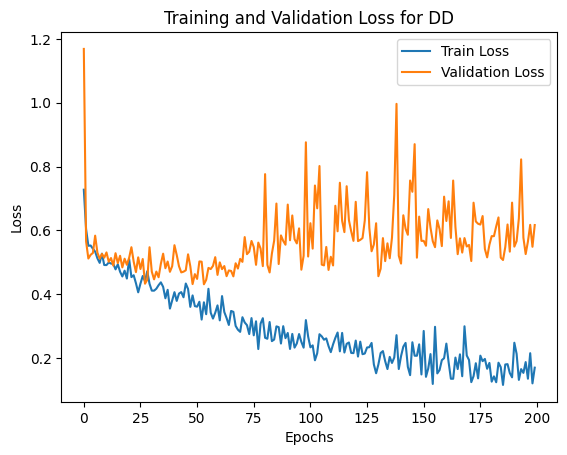

/tmp/ipykernel_30/3914440747.py:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=device))


Model loaded from models/best_model_DD.pth
Test Accuracy: 0.78
Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.94      0.82        63
           1       0.89      0.61      0.72        56

    accuracy                           0.78       119
   macro avg       0.81      0.77      0.77       119
weighted avg       0.81      0.78      0.77       119



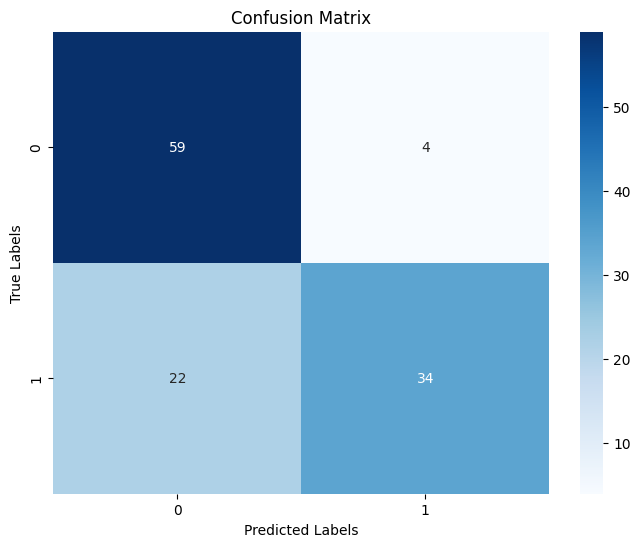

Best Validation Accuracy for DD: 0.85
Test Accuracy for DD: 0.78


In [16]:
main()